# Running simulations of the Foraging Ascomycete Model

<a id='contents'></a>
### contents

[Setup](#setup)  

[Survival of the...only? dispersal of one fungus.](#onefungus)  

[Changing initial abundances of wood](#initialwood)  

[Effect of wood deposition](#deposition)  

[Basic competition experiments](#basiccomp)

[Endophyte competition experiments](#endocompetition)

[Deforestation](#deforestation)

<a id='setup'></a>

In [17]:
from FAmodel import Forest
from FAmodel import sumendos
from FAmodel import sumdecomps
from FAagents import Tree, Wood, Fungus
import numpy as np
import matplotlib.pyplot as plt
import thomasprocess as tp
import pickle
import pandas as pd
%matplotlib inline

[back to contents](#contents)

<a id='onefungus'></a>

## Survival of the...only?

For our first parameter sweep, let's see what it takes to get established as a decomposer fungus new to an area that has recently been subject to nasty storm, with lots of wind-throw. This could represent a little bit of an ecological disturbance, blowing in fungal spores from far-away and a lot of fresh wood, with reduced loads of decomposer fungi on them (except for in-place wood-endophytes). 

To model this, we keep the model defaults of a fair amount of initial wood present on the landscape (ws = 30), and then a steady, lower rate of wood deposition from this point on. A blue fungus will appear in the beginning of the model but have no ability to disperse, so they won't expand beyond the initial log that they occupy.  

In [27]:
lvls = [ a for a in range(1,13,1) ]
runs = {}
for i in lvls: ## levels of variable
    run_list = []
    for j in range(100): ## number of simulations per level of parameter
        losced = Forest(
                endophytism = False, ## Turn off endos
                ws = 30,
                endodisp=0, ## Turn off endos
                decompdisp=i, ## variable of interest
                leafdisp = 4,
                leaffall = 1,
                numdecomp=1,
                numendo=1,
                endoloss=0.05,
                newwood = 6,
                woodfreq = 1,
                width = 100,
                kappa = 0.03,
                sigma = 3.0,
                mu = 2.2,
                        )
        for j in range(50): losced.step() ## number of steps before ending the model
        run_list.append(losced.datacollector.get_model_vars_dataframe())
        ## data into lists
    runs[i] = run_list

##pickle.dump(runs, open('onefungus_disp.p', 'wb'))

There aren't any endophytes in this scenario. When there are endophyte-capable fungi, we assign them blue, some of the above code reflects this. To visualize a run:

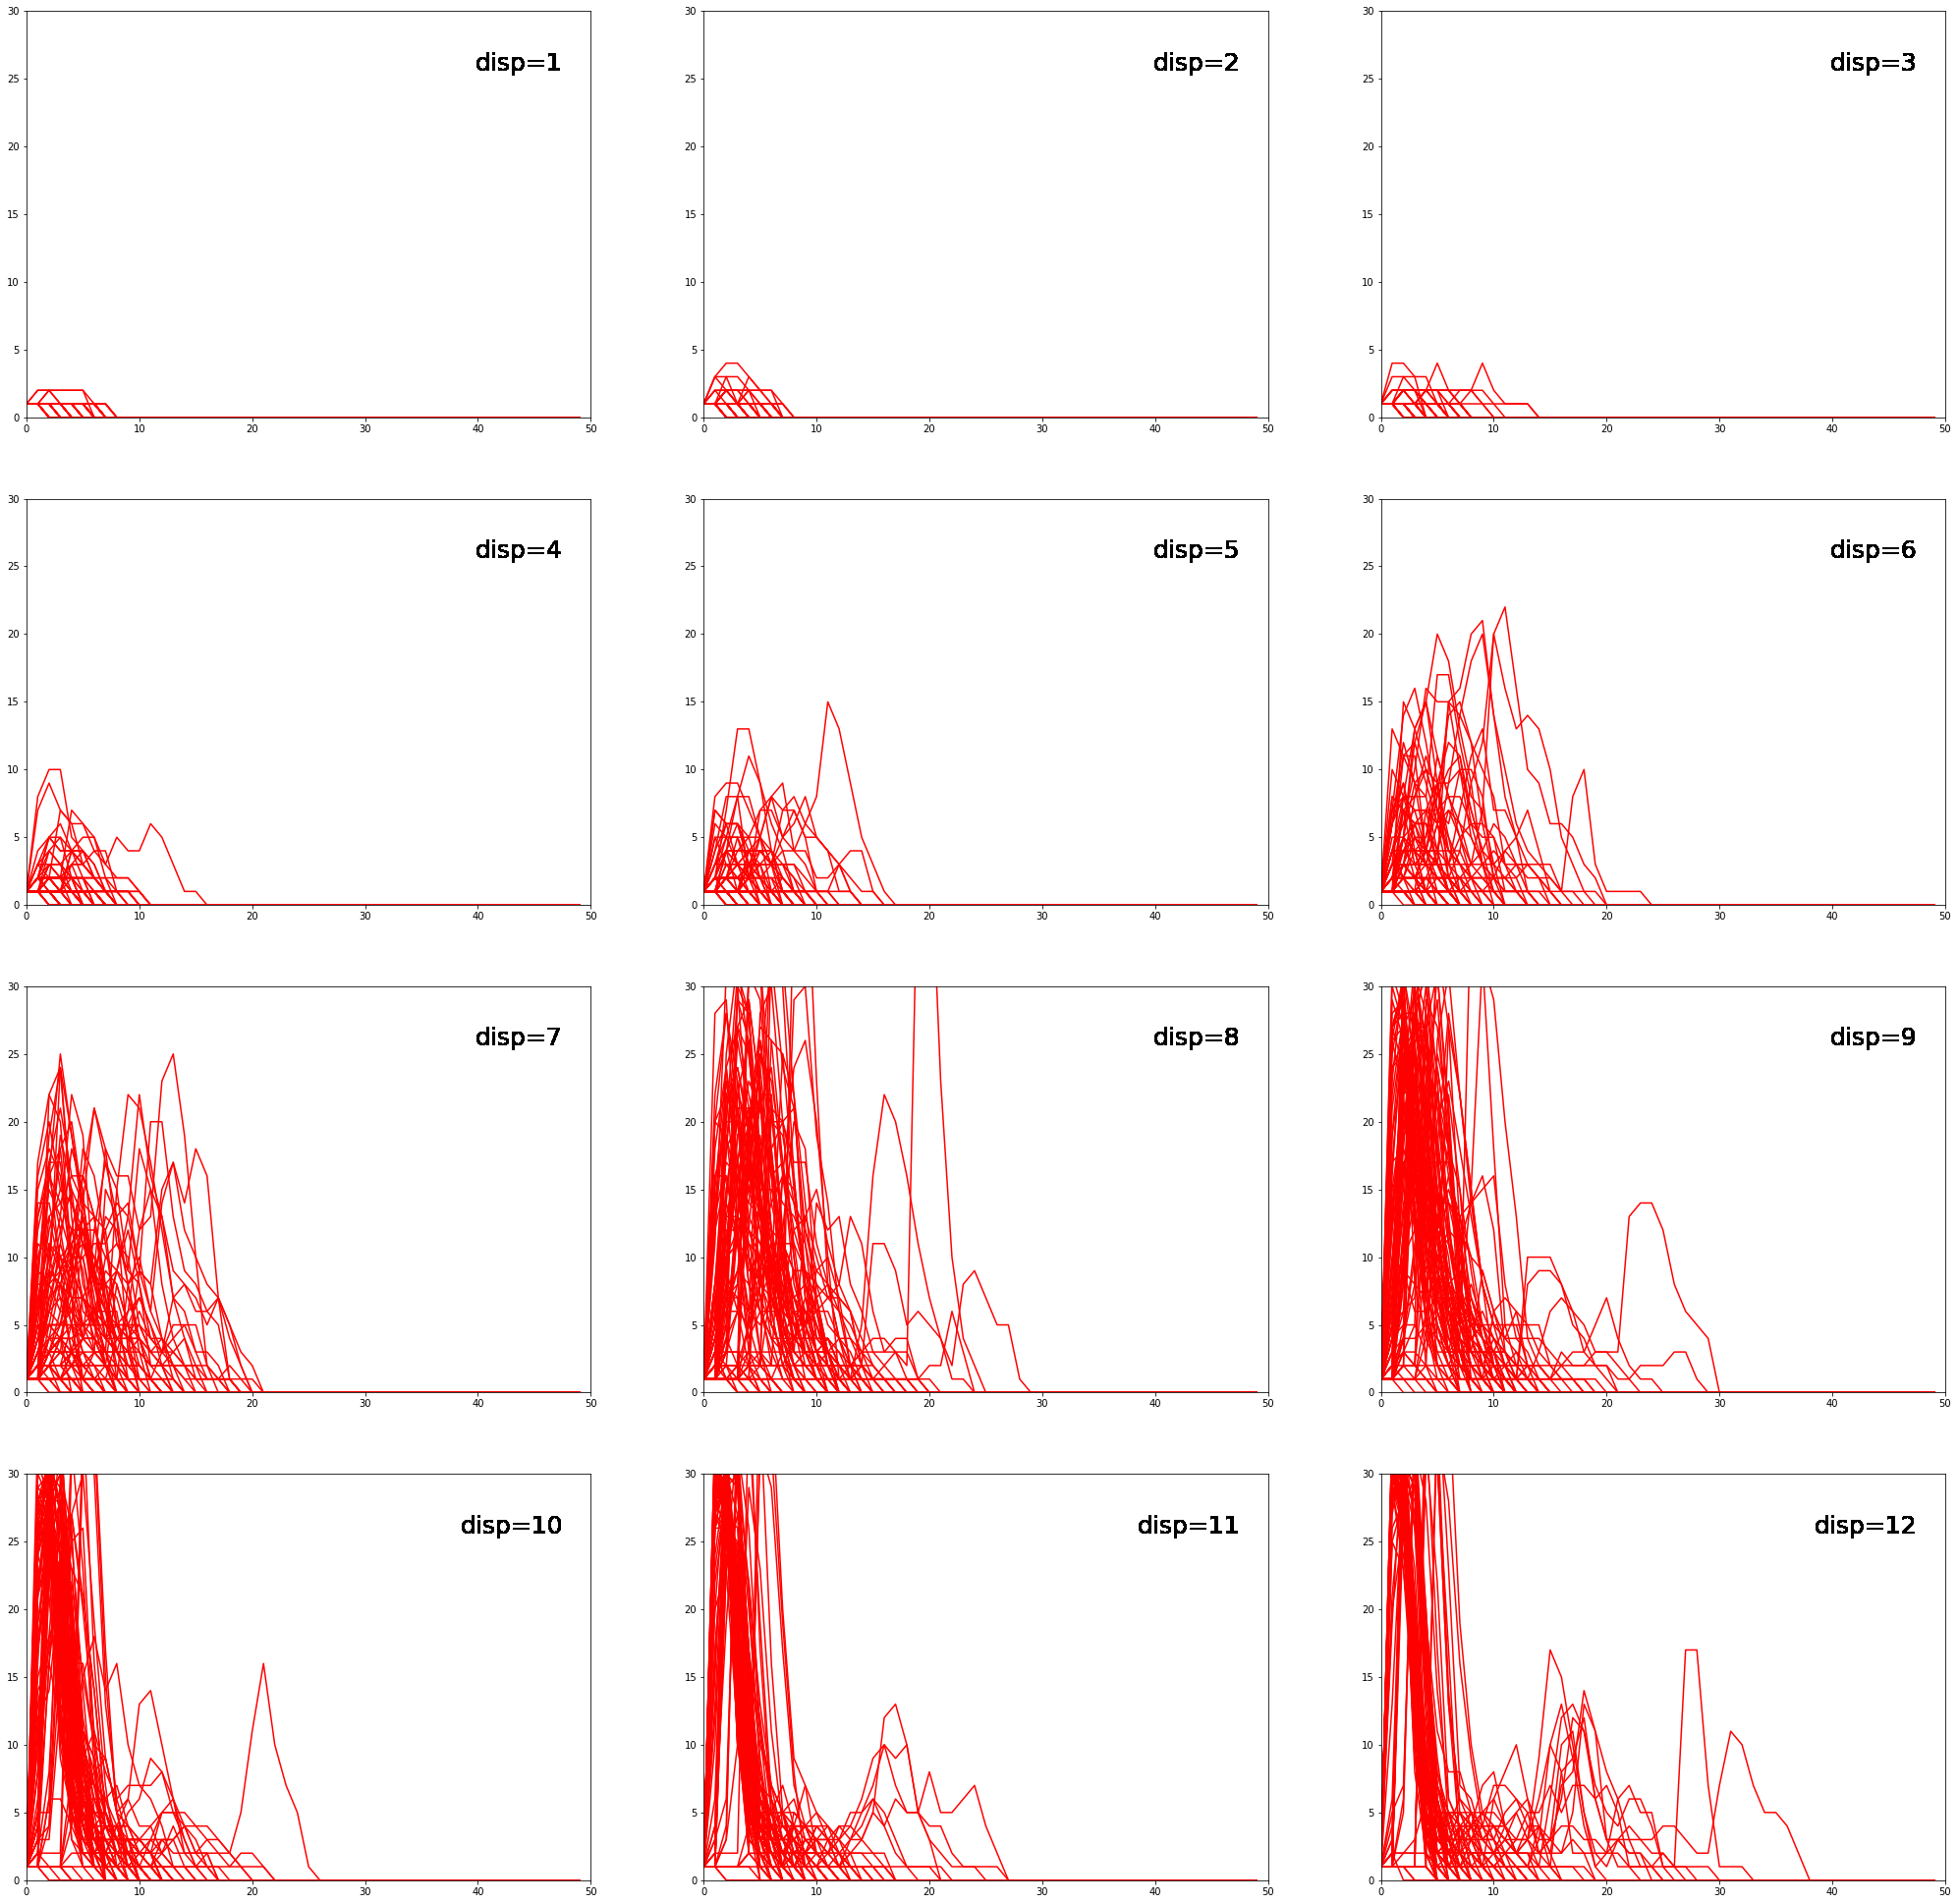

In [26]:
runs = pd.read_pickle('sweeps/results/onefungus_disp.p')

lvls = sorted(list(runs.keys()))#[::-1] ## lvls of the run, from large to small
fig, axes = plt.subplots(4,3, figsize=(35, 35)) ## set figure, nrows and ncols, sizes
for i,z in enumerate(axes.flatten()): ## unroll our array of subplots, deal with them 1-by-1
    z.set_ylim([0, 30])
    z.set_xlim([0, 50])
    for num,rrun in enumerate(runs[lvls[i]]): ## for all the runs of a given level
        z.plot([ x for x in range(50) ], rrun.Decomp_subs, c='r') ## plot a red line
        #z.plot([ x for x in range(50) ], rrun.Endo_subs, c='b') ## plot a blue
        z.text(.95, .9, 'disp=%s' % lvls[i], ## explain the variable, level
                #color='b',
                size='25',
                horizontalalignment='right',
                verticalalignment='top',
                transform=z.transAxes,
                )


It's cool to see the lines from all of the runs, but this can be a bit noisy to look at. So if we just plot the mean value of all the simulations of a given level of dispersal, but standard deviation of the runs from this mean, we can get a slightly cleaner view of what is going on. 

Our data comes to us from the simulations as dataframes, one per run of the model (50 steps per run, 100 runs per level of variable that we're interested in). This is pretty confusing, so let's build a function that parses this out for us into an easily plot-able format. The function below takes the output of the model sweep and spits out a dictionary of the mean number of substrates infected by a fungus at each time step, plus error values one standard deviation above and below this mean:
<a id='prettygraph'></a>

In [6]:
## a function, takes level of var (+ # of sims, default=50)  as argument:

def pldata(lvl,sims=50):
    means = []
    stds = []
    for j in range(sims): ## for all 50 time steps
        datime = [] ## decomposer abundances for a particular timestep, all 100 runs
        for i in runs[lvl]: ## for all the 100 sims from disp=1
            datime.append(i.Decomp_subs[j]) ## add this simulation's decomps total to the list
         ## calculate 
        means.append(np.mean(datime))
        stds.append(np.std(datime))
    updev = np.array(means) + np.array(stds) ## add error
    updev[updev < 0] = 0 ## get rid of negatives
    downdev = np.array(means) - np.array(stds) ## sub error
    downdev[downdev < 0] = 0 ## get rid of negatives
    pltdata = {'means':means,'updev':updev, 'downdev':downdev}
    return(pltdata)

This function is written to work on just one level of our parameter sweep. So loop through all the levels, make a dictionary:

In [28]:
lvls = sorted(list(runs.keys())) ## lvls of the run, from large to small
runplotdata = {}
for i in lvls:
    runplotdata[i] = pldata(i) ## create plotting data from each level of run results

Plot:

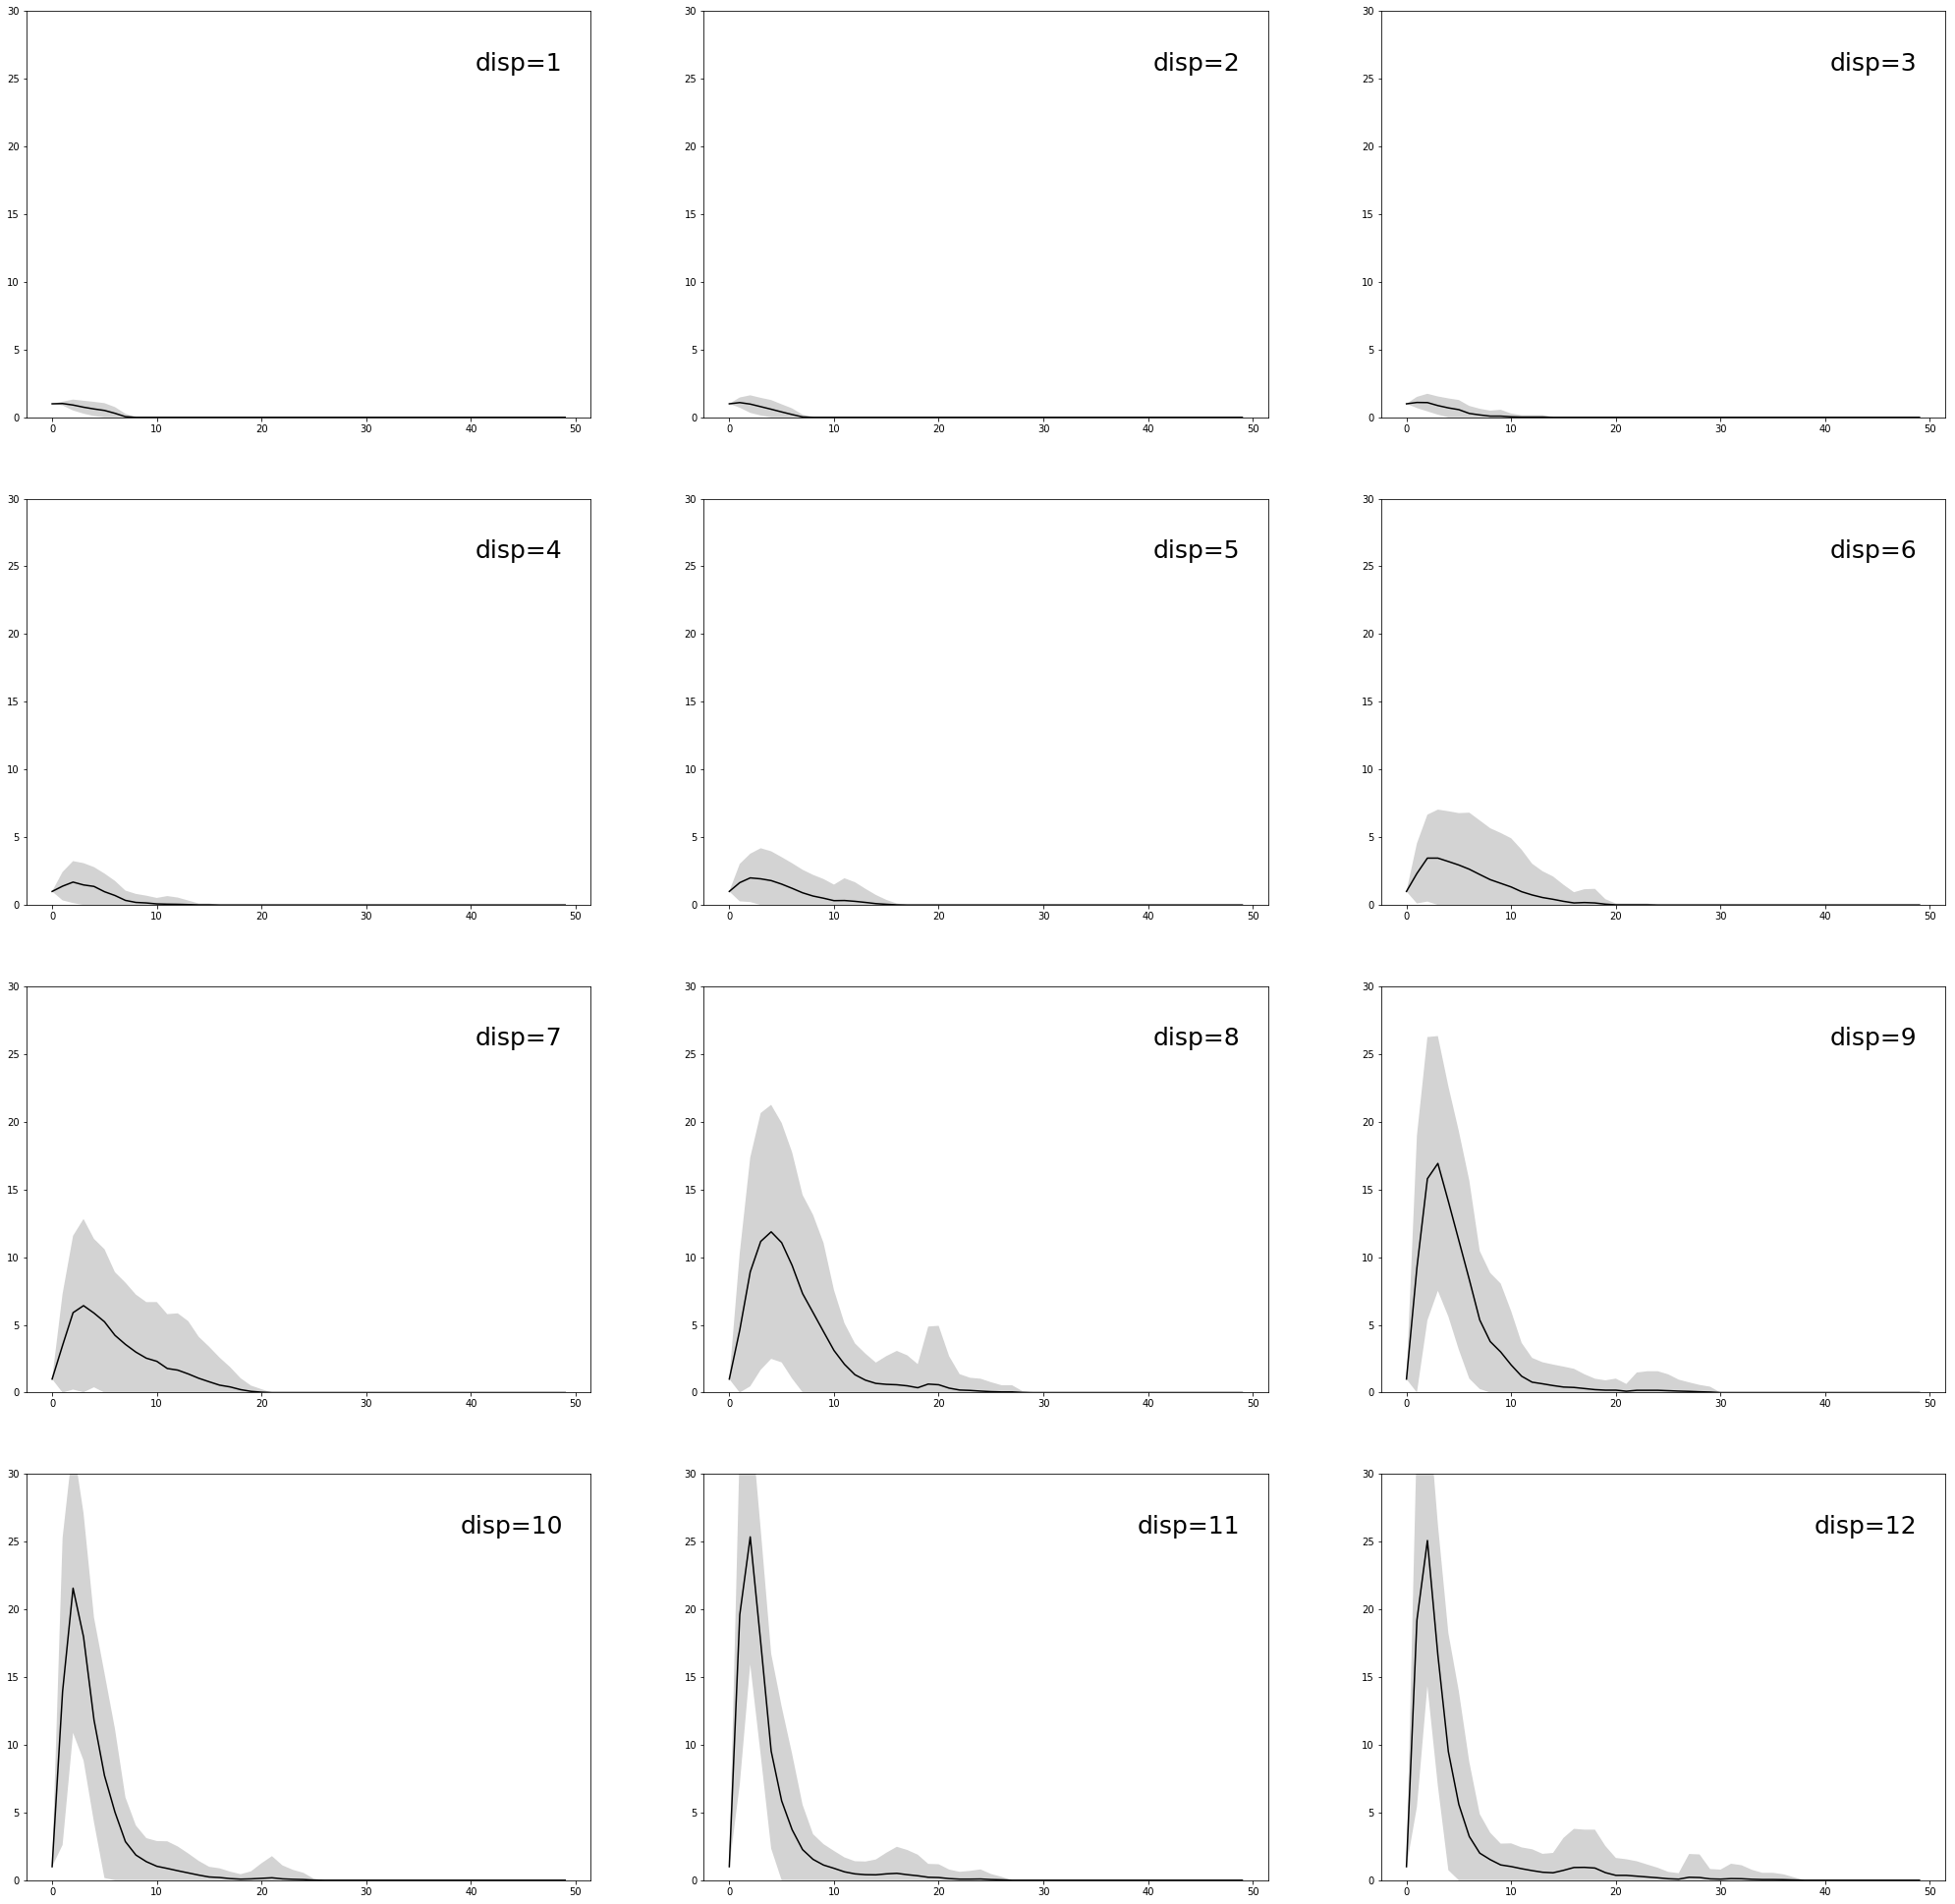

In [31]:
x = list(range(50))
fig, axes = plt.subplots(4,3, figsize=(35, 35)) ## set figure, nrows and ncols, sizes
for i,z in enumerate(axes.flatten()): ## unroll our array of subplots, deal with them 1-by-1
    z.plot(x, runplotdata[lvls[i]]['means'],'-',c='black')
    z.set_ylim(0,30)
    z.fill_between(x, runplotdata[lvls[i]]['updev'],
                    runplotdata[lvls[i]]['downdev'],
                    linewidth=0,
                    facecolor='lightgray',
                    )
    z.text(.95, .9, 'disp=%s' % lvls[i], ## explain the variable, level
            #color='b',
            size='25',
            horizontalalignment='right',
            verticalalignment='top',
            transform=z.transAxes,
            )


So here we see that agressive dispersal is a mixed blessing. Fungi rapidly colonize and consume the initial supply of wood in an area. Surprisingly, in these simulations, highly dispersed fungi seem to persist about as long on the landscape as less-well dispersed fungi, or not as long. It seems that success at wood colonization can result in low abundance of wood, a kind of predator-prey cycle that result in starvation of the fungal population if replacement rates of wood are slow. This is of course assumes that a fungus doesn't persist in soil, etc, to recolonize wood as it becomes available, and assumes no immigration into the system.  

The lesson here? Some sort of lower-energy, lower-fitness-reward solution may be necessary to for most fungi in addition to spore dispersal a world of finite resources and dispersal, lest they become victims of their own success. 

[back to contents](#contents)

<a id='initialwood'></a>

## Changing initial abundances of wood

Can we create a situation where the single species of decomposer, spore-dispersed fungus can persist on the landscape? From the above trials, a spore dispersal coefficient of ~5 seems to represent the best compromise on the boom-bust-starve effect vs. stranding from underdispersion. We can hold this dispersal coefficient constant and vary the wood initial abundance and wood-deposition rates. So first, what will it look like if we vary initial abundances of wood?

In [35]:
decomp_runs = {}
for i in [ i for i in range(20,105,5) ]: ## levels of variable
    endo_list = []
    decomp_list = []
    for j in range(100): ## number of simulations per level of parameter
        losced = Forest(endophytism = False, ##settings for model
                        ws=i, ## parameter of interest
                        decompdisp=5, ## hold fungal dispersal here
                        endodisp=0, ## no blue fungi
                       )
        for j in range(50): losced.step() ## number of steps before ending the model
        ## data into lists
        endo_list.append(losced.datacollector.get_model_vars_dataframe().Endophytes)
        decomp_list.append(losced.datacollector.get_model_vars_dataframe().Decomposers)
   endo_runs[i] = endo_list
    decomp_runs[i] = decomp_list

#pickle.dump(endo_runs, open('blue_runs.p', 'wb'))
#pickle.dump(decomp_runs, open('red_runs.p', 'wb'))


In [51]:
#red_runs = pickle.load(open('/home/daniel/Documents/ABM/FA/sweeps/results/ws_d5.p','rb'))

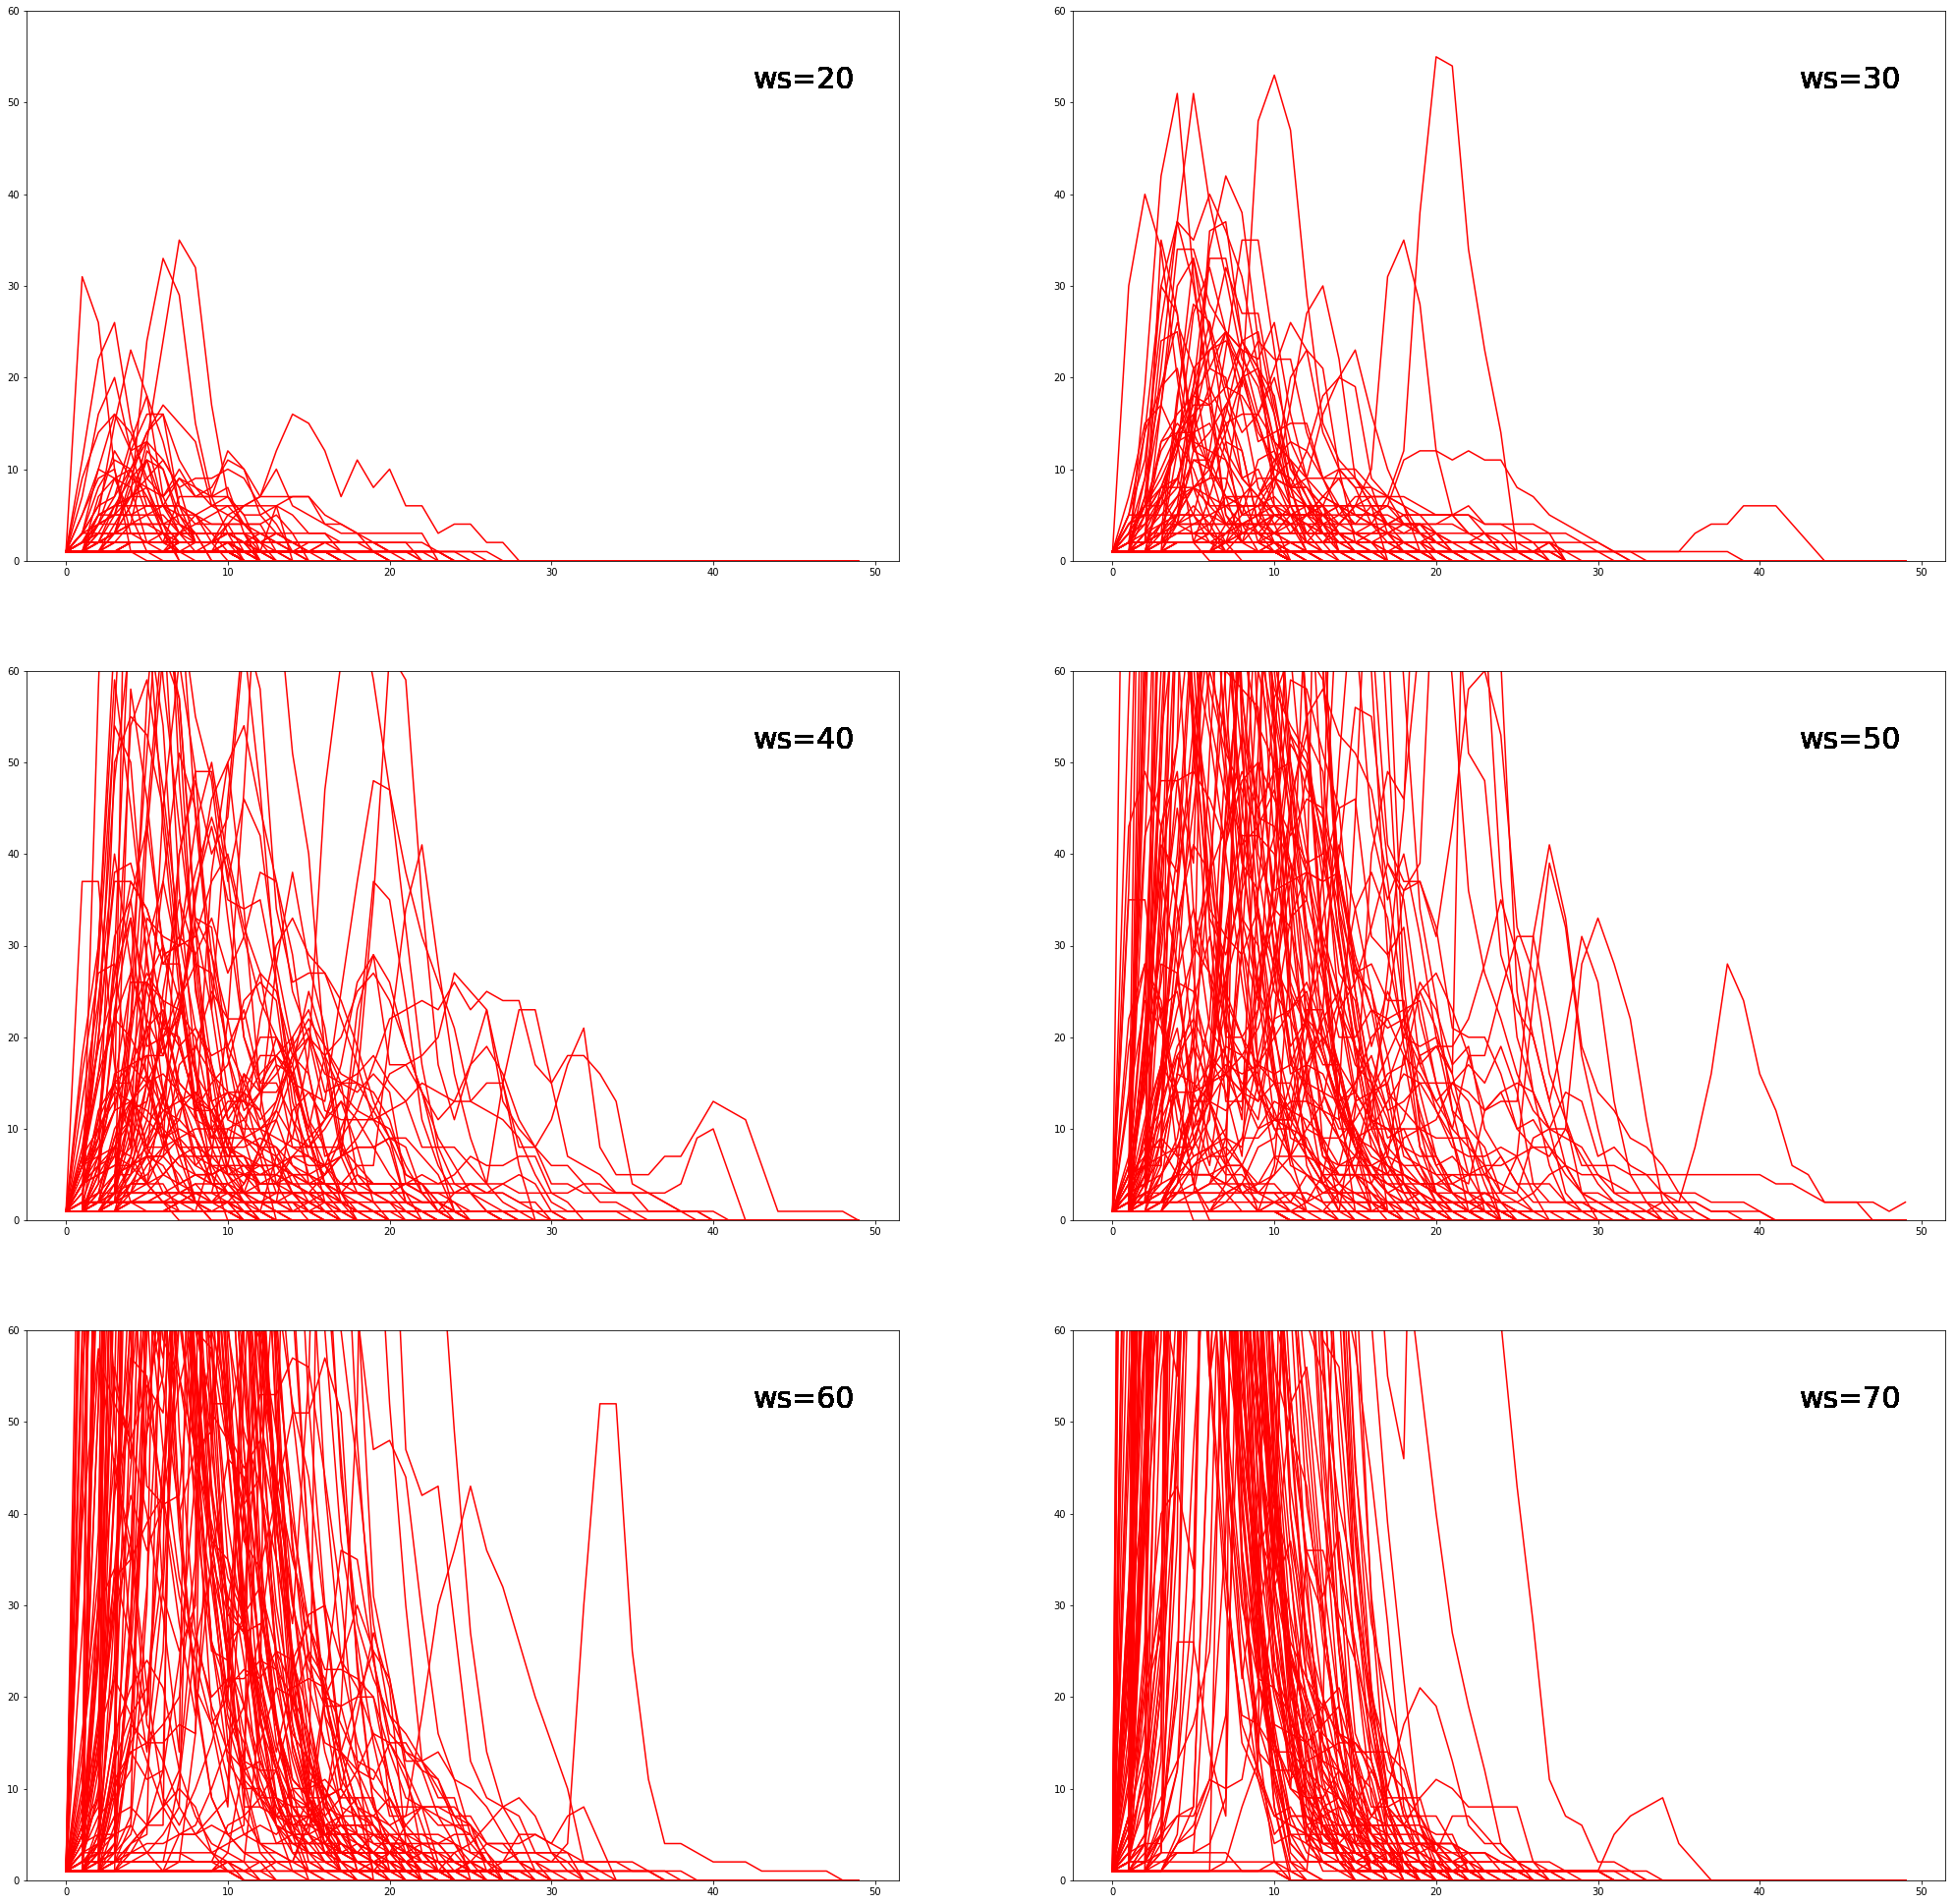

In [60]:
fig, axes = plt.subplots(3,2, figsize=(35, 35)) ## set figure, nrows and ncols, sizes
lvls = sorted(list(red_runs.keys())) ## levels of the run
for i,z in enumerate(axes.flatten()): ## unroll our array of subplots, deal with them 1-by-1
    for j in red_runs[lvls[i]]: ## plot all of our red fungi of a given level
        z.set_ylim([0, 60])
        z.plot([ h for h in range(50) ], j, c='r')
        z.text(.95, .9, 'ws=%s' % lvls[i],
                #color='r',
                size='30',
                horizontalalignment='right',
                verticalalignment='top',
                transform=z.transAxes)

[back to contents](#contents)

<a id='deposition'></a>
## Effect of wood deposition rates

Here we assume an initial wood amount of 30 logs on the site, a medium-strong dispersing fungus (not endophyte-competent), and sweep over the rate of new wood deposition on the landscape. Note we aren't varying the frequency here of new log deposition, it is kept the current model default of once every three steps. The amount of logs that are being dropped over the landscape are being varied.

In [33]:
with open('updates_newwood.txt', 'a') as upd:
    lvls = [ a for a in range(1,10,1) ]
    runs = {}
    for i in lvls: ## levels of variable
        run_list = []
        upd.write('starting level: %s \n' %i)
        for j in range(100): ## number of simulations per level of parameter
            losced = Forest(
                    endophytism = False, ## Turn off endos
                    ws = 30,
                    endodisp=0, ## Turn off endos
                    decompdisp=8, 
                    leafdisp = 4,
                    leaffall = 1,
                    numdecomp=1,
                    numendo=1,
                    endoloss=0.05,
                    newwood = i, ## variable of interest
                    woodfreq = 1,
                    width = 100,
                    kappa = 0.03,
                    sigma = 3.0,
                    mu = 2.2,
                            )
            for j in range(50): losced.step() ## number of steps before ending the model
            run_list.append(losced.datacollector.get_model_vars_dataframe())
        upd.write('completed level: %s \n' %i)
            ## data into lists
        runs[i] = run_list

#pickle.dump(runs, open('newwood_sweep.p', 'wb'))

Visualize, with all plot lines:

In [35]:
runs = pd.read_pickle('sweeps/results/newwood_sweep_1of2.p')

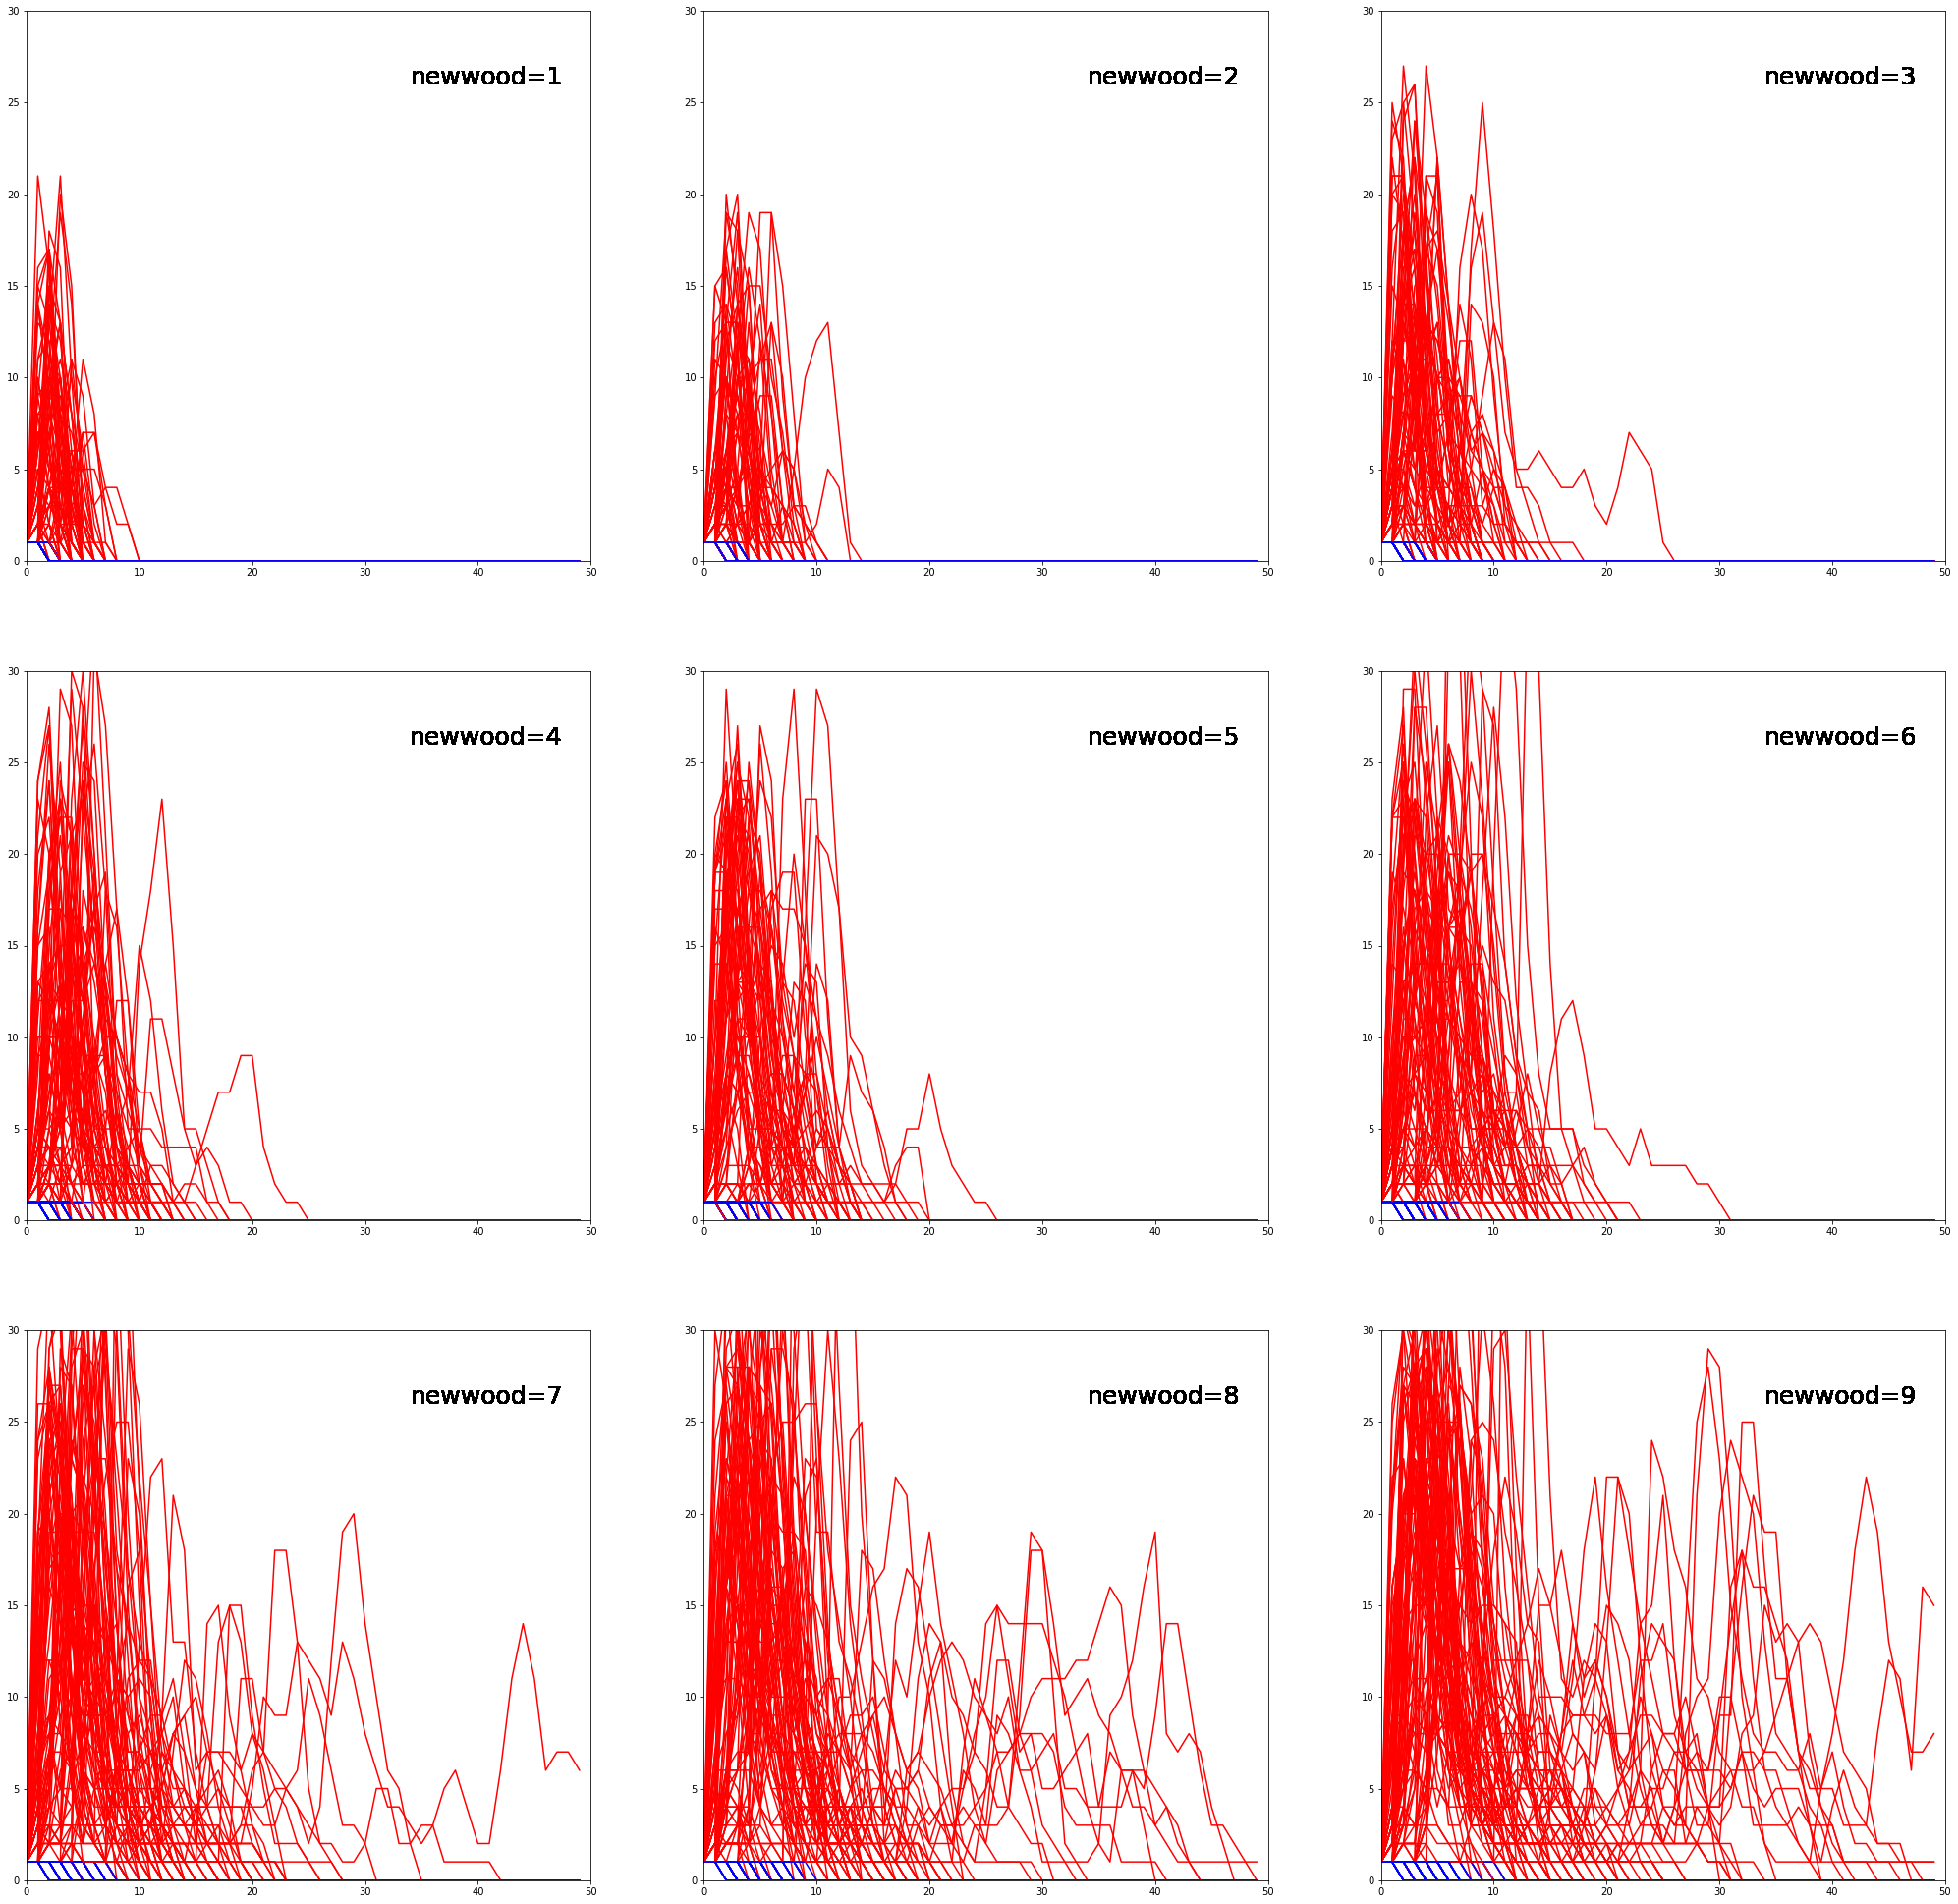

In [38]:
lvls = sorted(list(runs.keys()))#[::-1] ## lvls of the run, from large to small

fig, axes = plt.subplots(3,3, figsize=(35, 35)) ## set figure, nrows and ncols, sizes
for i,z in enumerate(axes.flatten()): ## unroll our array of subplots, deal with them 1-by-1
    z.set_xlim([0, 50])
    for num,rrun in enumerate(runs[lvls[i]]): ## for all the runs of a given level
        z.plot([ x for x in range(50) ], rrun.Decomp_subs, c='r') ## plot a red line
        z.plot([ x for x in range(50) ], rrun.Endo_subs, c='b') ## plot a blue
        z.text(.95, .9, 'newwood=%s' % lvls[i], ## explain the variable, level
                #color='b',
                size='25',
                horizontalalignment='right',
                verticalalignment='top',
                transform=z.transAxes,
              )

And using the [same function](#prettygraph) above to parse our dataframes from each run:

In [39]:
lvls = sorted(list(runs.keys())) ## lvls of the run, from large to small
x = list(range(50))
runplotdata = {}
for i in lvls:
    runplotdata[i] = pldata(i) ## create plotting data from each level of run results

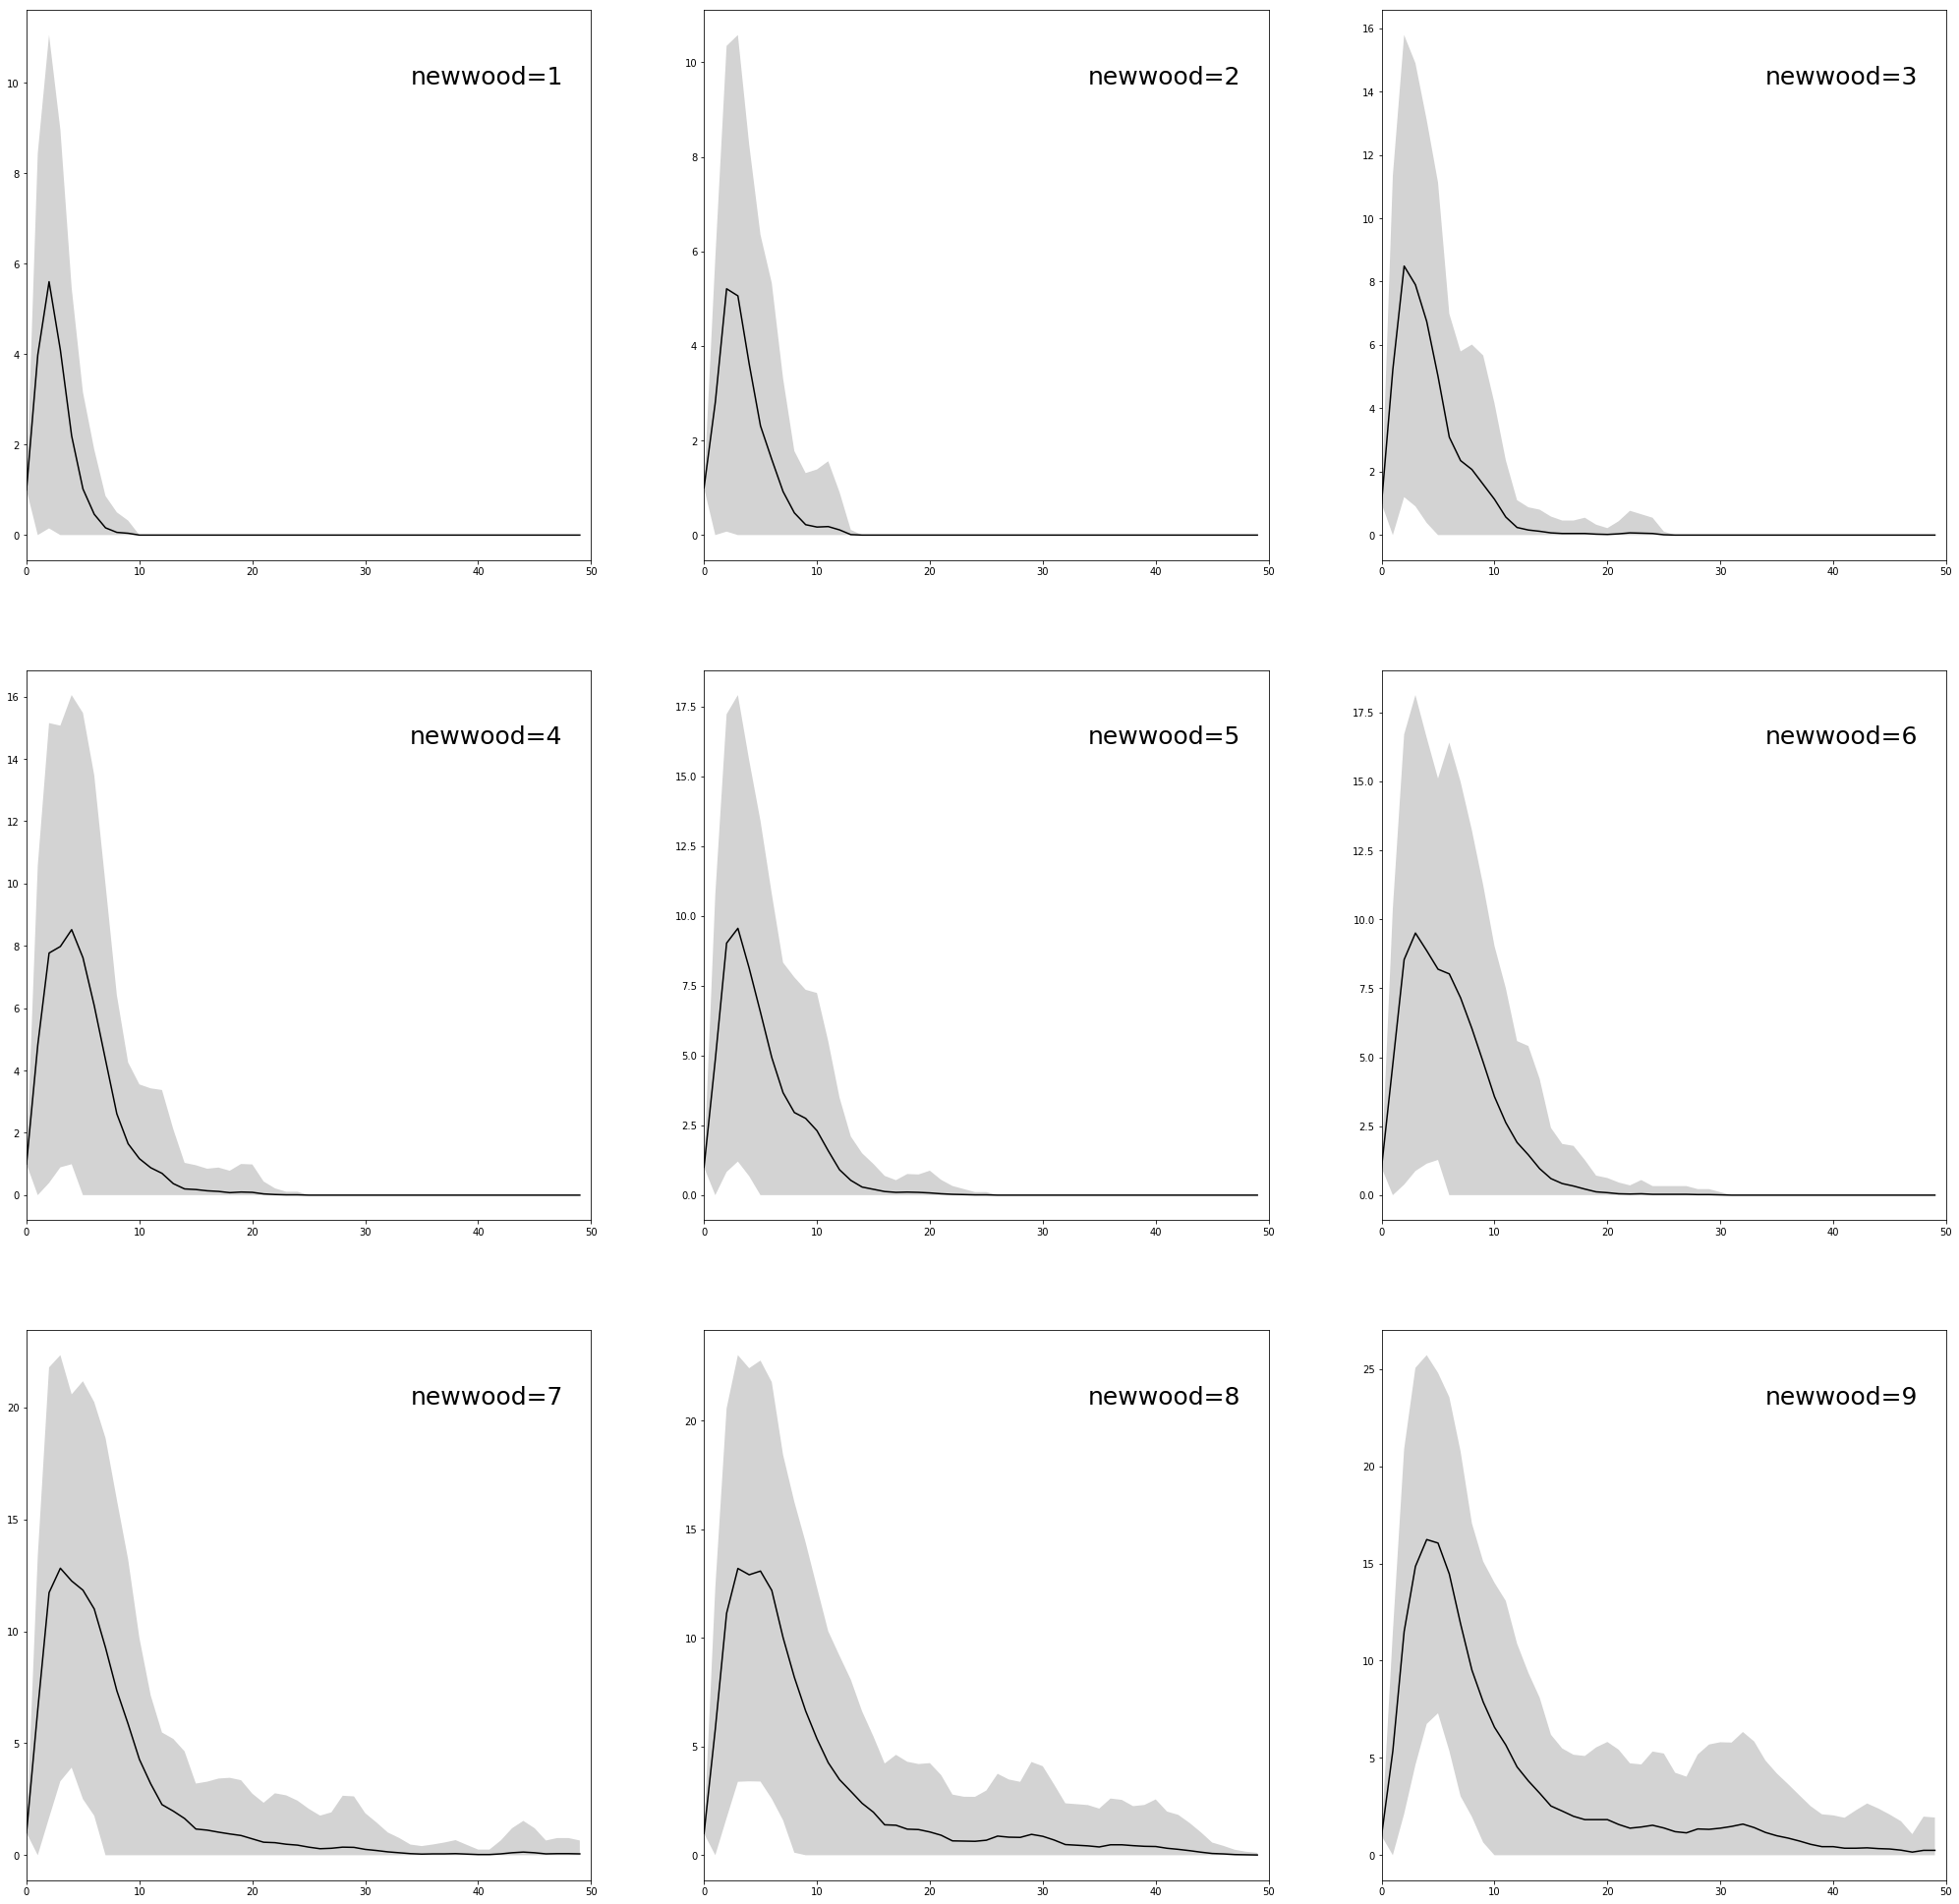

In [41]:
fig, axes = plt.subplots(3,3, figsize=(35, 35)) ## set figure, nrows and ncols, sizes
for i,z in enumerate(axes.flatten()): ## unroll our array of subplots, deal with them 1-by-1
    z.plot(x, runplotdata[lvls[i]]['means'],'-',c='black')
    z.set_xlim([0, 50])
    z.fill_between(x, runplotdata[lvls[i]]['updev'],
                    runplotdata[lvls[i]]['downdev'],
                    linewidth=0,
                    facecolor='lightgray',
                    )
    z.text(.95, .9, 'newwood=%s' % lvls[i], ## explain the variable, level
            #color='b',
            size='25',
            horizontalalignment='right',
            verticalalignment='top',
            transform=z.transAxes,
            )



Seems like it will take more wood to keep a fungus around on the 100 ha scale. Let's check higher rates of wood deposition:

In [44]:
runs = pd.read_pickle('sweeps/results/newwood_sweep_2of2.p')

In [45]:
lvls = sorted(list(runs.keys())) ## lvls of the run, from large to small
x = list(range(50))
runplotdata = {}
for i in lvls:
    runplotdata[i] = pldata(i) ## create plotting data from each level of run results

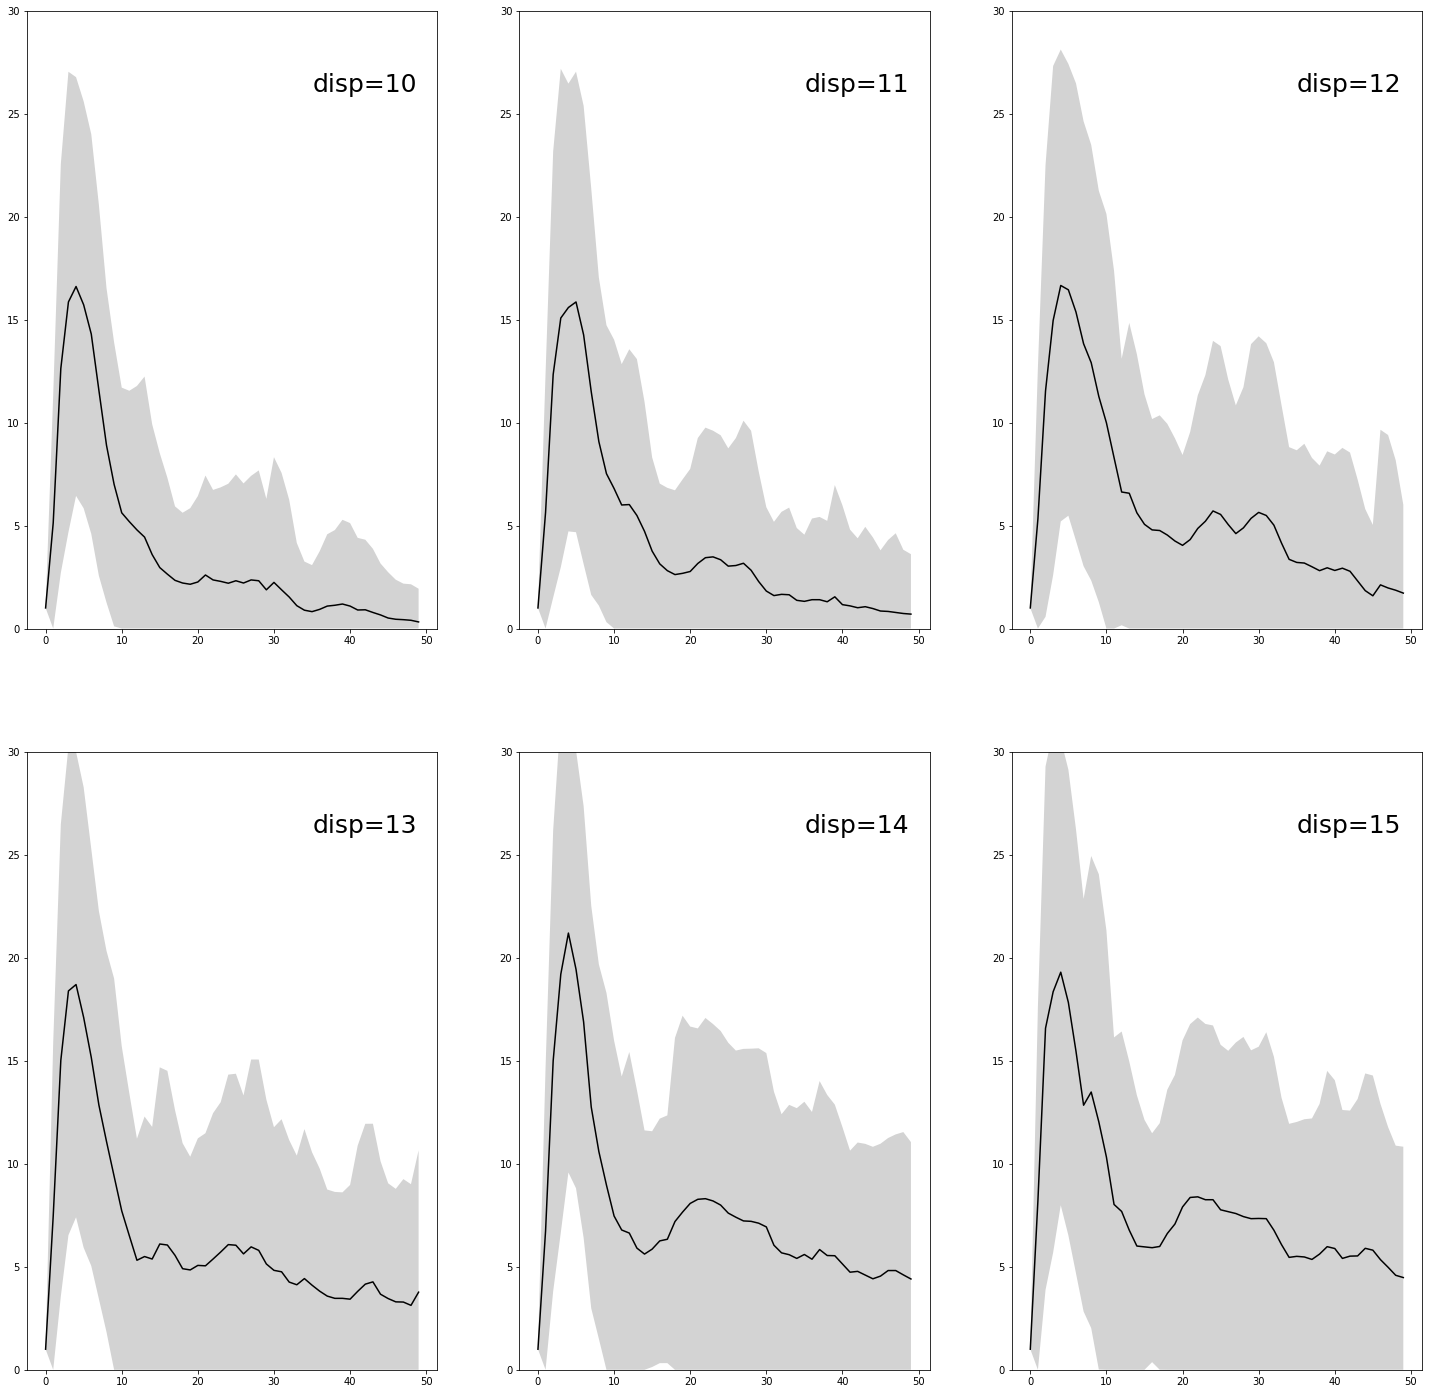

In [47]:
x = list(range(50))
fig, axes = plt.subplots(2,3, figsize=(25, 25)) ## set figure, nrows and ncols, sizes
for i,z in enumerate(axes.flatten()): ## unroll our array of subplots, deal with them 1-by-1
    z.plot(x, runplotdata[lvls[i]]['means'],'-',c='black')
    z.set_ylim(0,30)
    z.fill_between(x, runplotdata[lvls[i]]['updev'],
                    runplotdata[lvls[i]]['downdev'],
                    linewidth=0,
                    facecolor='lightgray',
                    )
    z.text(.95, .9, 'disp=%s' % lvls[i], ## explain the variable, level
            #color='b',
            size='25',
            horizontalalignment='right',
            verticalalignment='top',
            transform=z.transAxes,
            )


So, it looks like we need at least 13 units of energy in wood laid down each turn to keep some EC- fungi on the landscape, with a dispersal coefficient of 8.

[back to contents](#contents)

<a id='basiccomp'></a>
## Basic competition experiments

Let's examine what happens when we compete two fungi, not endophyte-competent. We'll hold one species' dispersal ability constant at d=8, and vary the other's from 4 to 12. 

In [2]:
with open('updates_decomp_comp.txt', 'a') as upd:
    lvls = list(range(4,13,1))
    runs = {}
    for i in lvls: ## levels of variable
        run_list = []
        upd.write('starting level: %s \n' %i)
        for j in range(100): ## number of simulations per level of parameter
            losced = Forest(
                    endophytism = False, ## Turn off endos
                    ws = 30,
                    endodisp=i, ## variable of interest
                    decompdisp=8, 
                    leafdisp = 4,
                    leaffall = 1,
                    numdecomp=1,
                    numendo=1,
                    endoloss=0.05,
                    newwood = 6,
                    woodfreq = 1,
                    width = 100,
                    kappa = 0.03,
                    sigma = 3.0,
                    mu = 2.2,
                            )
            for j in range(50): losced.step() ## number of steps before ending the model
            run_list.append(losced.datacollector.get_model_vars_dataframe())
        upd.write('completed level: %s \n' %i)
            ## data into lists
        runs[i] = run_list

#pickle.dump(runs, open('decomp_comp.p', 'wb'))

In [16]:
#runs = pd.read_pickle('sweeps/results/decomp_comp_wrong.p')

Let's modify [our parsing-for-plotting function](#prettygraph) to handle both species from our dataframes from each run:

In [15]:
def pldata(lvl,sims=50):
    decomp_means = []
    decomp_stds = []
    endo_means = []
    endo_stds = []
    for j in range(sims): ## for all 50 time steps
        datime = [] ## decomposer abundances for a particular timestep, all 100 runs
        eatime = [] ## endophyte abundances for a particular timestep, all 100 runs
        for i in runs[lvl]: ## for all the 100 sims from disp=j
            datime.append(i.Decomp_subs[j]) ## add this simulation's decomps total to the list
            eatime.append(i.Endo_subs[j]) ## add this simulation's endophyte total to the list
         ## create the time series of means and stdevs:
        decomp_means.append(np.mean(datime))
        decomp_stds.append(np.std(datime))
        endo_means.append(np.mean(eatime))
        endo_stds.append(np.std(eatime))
    ## decomp error zone:
    decomp_updev = np.array(decomp_means) + np.array(decomp_stds) ## add error
    decomp_updev[decomp_updev < 0] = 0 ## get rid of negatives
    decomp_downdev = np.array(decomp_means) - np.array(decomp_stds) ## sub error
    decomp_downdev[decomp_downdev < 0] = 0 ## get rid of negatives
    ## decomp error zone:
    endo_updev = np.array(endo_means) + np.array(endo_stds) ## add error
    endo_updev[endo_updev < 0] = 0 ## get rid of negatives
    endo_downdev = np.array(endo_means) - np.array(endo_stds) ## sub error
    endo_downdev[endo_downdev < 0] = 0 ## get rid of negatives
    ## store it in a dictionary:
    pltdata = {'decomp_means':decomp_means,
                'decomp_updev':decomp_updev,
                'decomp_downdev':decomp_downdev,
                'endo_means':endo_means,
                'endo_updev':endo_updev,
                'endo_downdev':endo_downdev,
              }
    return(pltdata)


In [18]:
lvls = sorted(list(runs.keys())) ## lvls of the run, from large to small
x = list(range(50))
runplotdata = {}
for i in lvls:
    runplotdata[i] = pldata(i) ## create plotting data from each level of run results

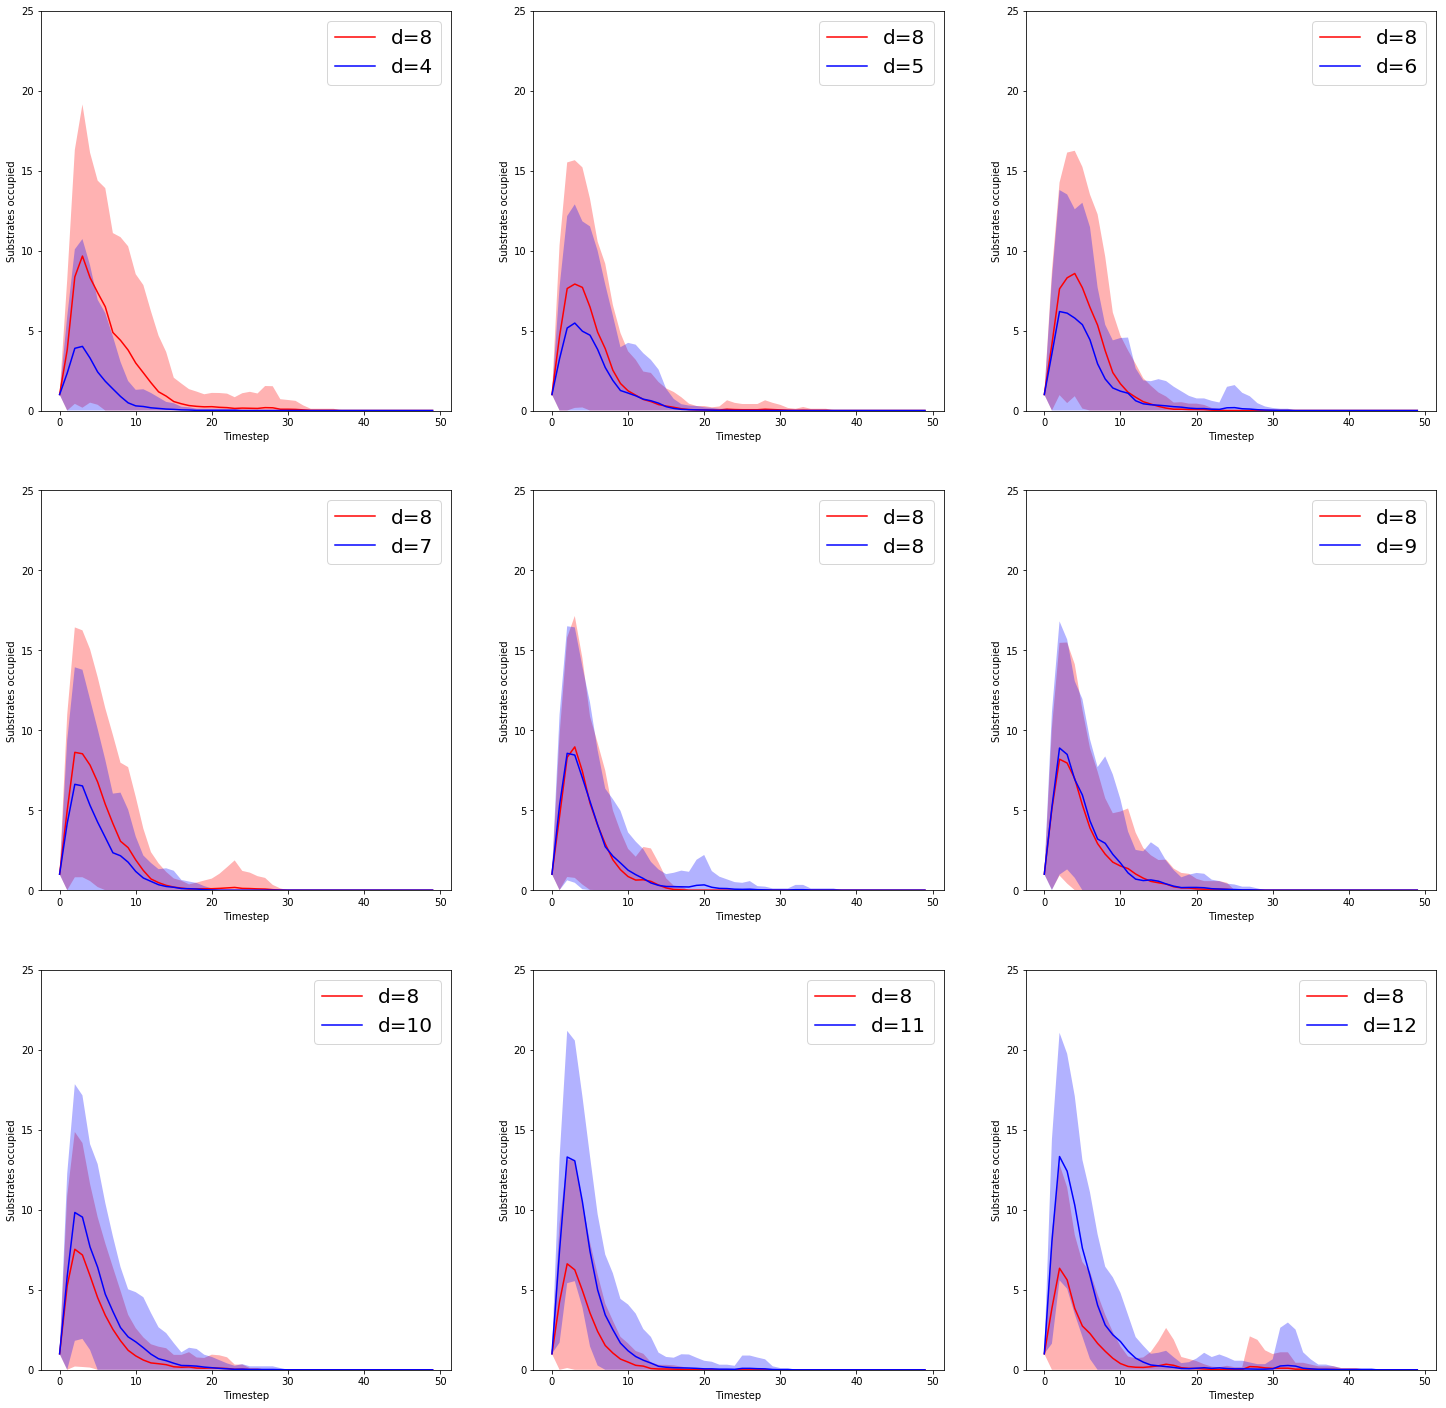

In [24]:
x = list(range(50))
fig, axes = plt.subplots(3,3, figsize=(25, 25)) ## set figure, nrows and ncols, sizes
for i,z in enumerate(axes.flatten()): ## unroll our array of subplots, deal with them 1-by-1
    z.set_ylim(0,25) ## yaxis
    ## plot red:
    z.plot(x, runplotdata[lvls[i]]['decomp_means'],
            '-',
            c='red',
            label=('d=8'),
            )
    ## plot blue:
    z.plot(x, runplotdata[lvls[i]]['endo_means'],
            '-',
            c='blue',
            label=('d=%s' %lvls[i]),
            )
    ## red error fill
    z.fill_between(x, runplotdata[lvls[i]]['decomp_updev'],
                    runplotdata[lvls[i]]['decomp_downdev'],
                    linewidth=0,
                    facecolor='red',
                    alpha = 0.3,
                    )
    ## blue error fill
    z.fill_between(x, runplotdata[lvls[i]]['endo_updev'],
                    runplotdata[lvls[i]]['endo_downdev'],
                    linewidth=0,
                    facecolor='blue',
                    alpha = 0.3,
                    )
    handles, labels = z.get_legend_handles_labels()
    z.legend(handles, labels, prop={'size':20})
    z.set_ylabel("Substrates occupied")
    z.set_xlabel("Timestep")


[back to contents](#contents)

<a id='endocompetition'></a>

## Endophyte competition experiments

So in the default forest we're working with, what does it take to compete with our "average" decomposer with dispersal = 5? We'll say that with trees d=1, with decomposers d=5, and sweep endophyte spores from d = 1 to 7. Endophyte loss is low, 1% per step. What does this look like?


In [5]:
#import pickle
#from FAmodel import Forest
#from FAmodel import sumendos
#from FAmodel import sumdecomps
#from FAagents import Tree, Wood, Fungus
#import numpy as np
#import matplotlib.pyplot as plt
#import thomasprocess as tp


runs = {}
for i in [ a for a in range(1,8,1) ]: ## levels of variable
    run_list = []
    for j in range(100): ## number of simulations per level of parameter
        losced = Forest(endophytism = True, ##settings for model
                        ws = 30,
                        woodfreq = 1,
                        newwood = 4,
                        endodisp = i, ## parameter of interest
                        decompdisp=5, 
                        )
        for j in range(50): losced.step() ## number of steps before ending the model
        ## data into lists
        run_list.append(losced.datacollector.get_model_vars_dataframe())
    runs[i] = run_list
    
#pickle.dump(runs, open('first_endo_comp.p', 'wb'))

In [7]:
runs = pd.read_pickle('sweeps/results/first_endo_comp.p')

IndexError: list index out of range

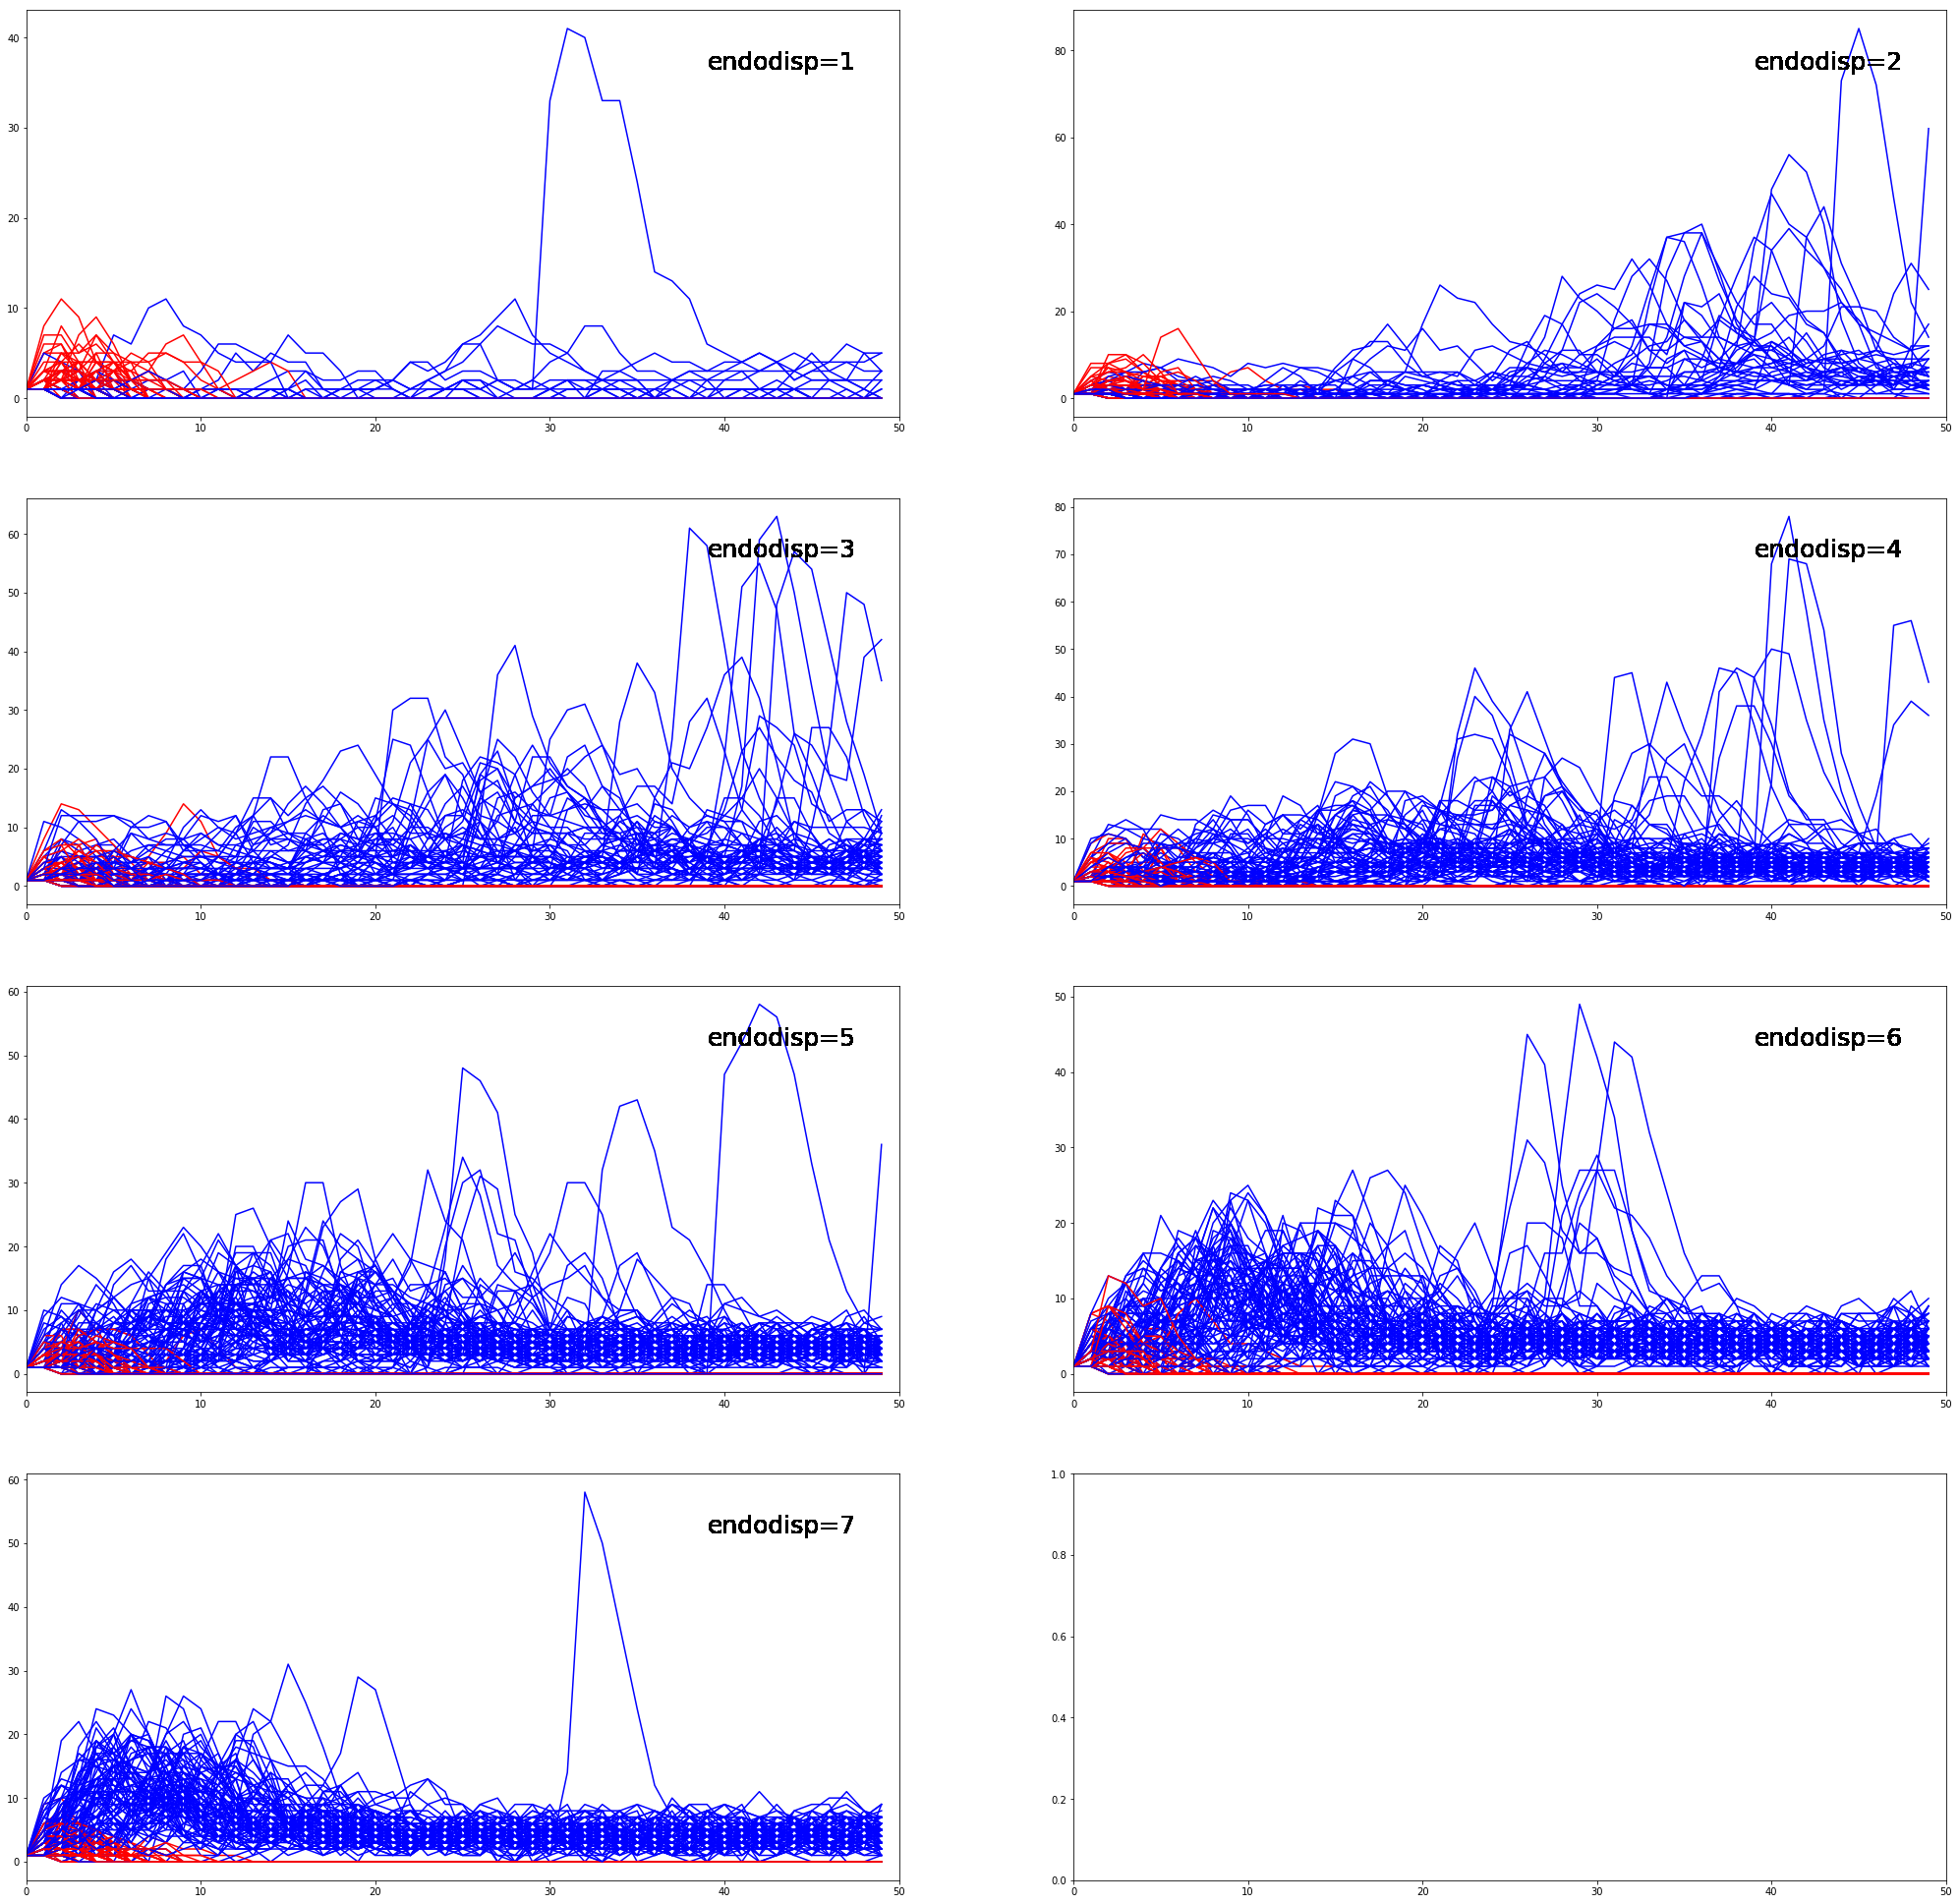

In [10]:
lvls = sorted(list(runs.keys())) ## lvls of the run, from large to small
fig, axes = plt.subplots(4,2, figsize=(35, 35)) ## set figure, nrows and ncols, sizes
for i,z in enumerate(axes.flatten()): ## unroll our array of subplots, deal with them 1-by-1
    #z.set_ylim([0, 50])
    z.set_xlim([0, 50])
    for num,rrun in enumerate(runs[lvls[i]]): ## for all the runs of a given level
        z.plot([ x for x in range(50) ], rrun.Decomp_subs, c='r') ## plot a red line
        z.plot([ x for x in range(50) ], rrun.Endo_subs, c='b') ## plot a blue
        z.text(.95, .9, 'endodisp=%s' % lvls[i], ## explain the variable, level
                #color='b',
                size='25',
                horizontalalignment='right',
                verticalalignment='top',
                transform=z.transAxes,
                )

Wow, as modeled here, EC+ fungi quickly swamp the EC- fungi. This is informative, but I think we need to check the base dispersal of our "average" decomposer - it's dying out. This may be due to our new wood deposition algorithm. 

[back to contents](#contents)

<a id='deforestation'></a>

## Deforestation 

We can see how these EC+ and EC-  compete after dispersing to a new harvest event, modeled as a lot of fresh slash on the ground, and increasingly fewer trees on the landscape. We do this by lowering the "kappa" setting in our model, which is the number of clusters of trees on the landscape. This is a little different than looking at what happens to a landscape with existing fungi in the leaves and on the forest floor (for that I would have to modify the model a little, to allow tree death...).

In [11]:
-

In [18]:
runs = pd.read_pickle('sweeps/results/deforest_kappa_labcomp.p')

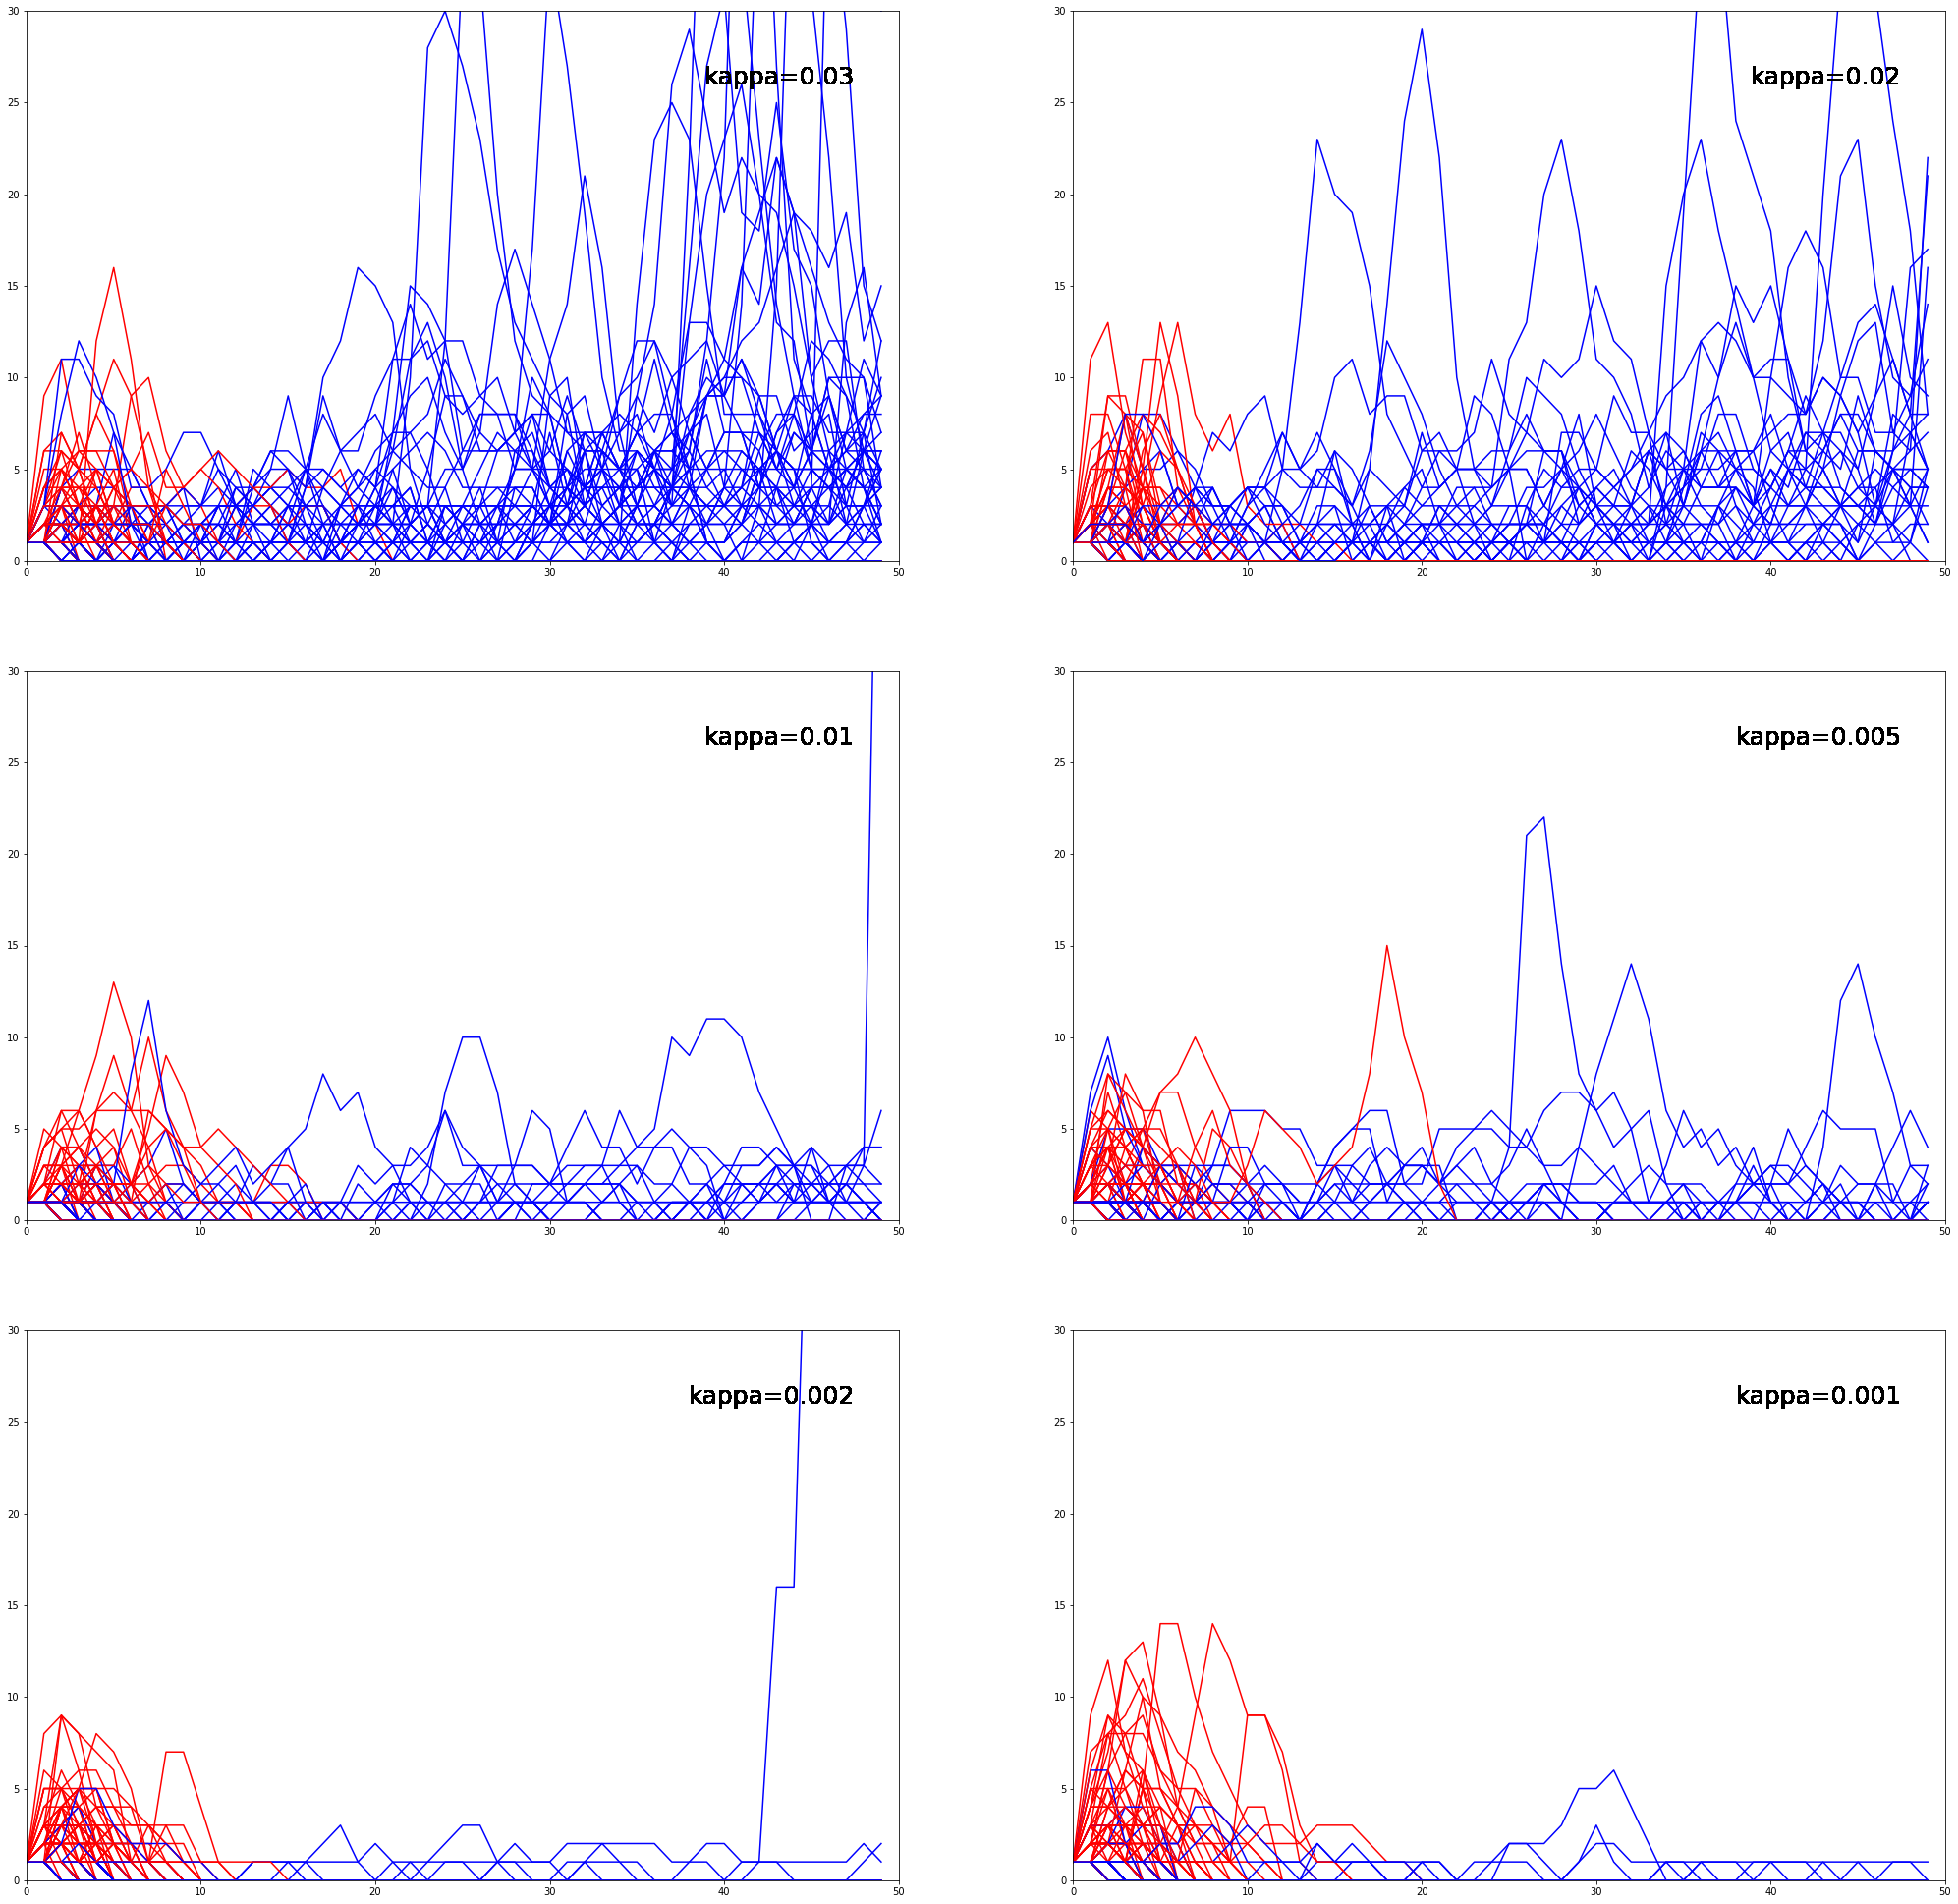

In [22]:
lvls = sorted(list(runs.keys()))[::-1] ## lvls of the run, from large to small
fig, axes = plt.subplots(3,2, figsize=(35, 35)) ## set figure, nrows and ncols, sizes
for i,z in enumerate(axes.flatten()): ## unroll our array of subplots, deal with them 1-by-1
    z.set_ylim([0, 30])
    z.set_xlim([0, 50])
    for num,rrun in enumerate(runs[lvls[i]]): ## for all the runs of a given level
        z.plot([ x for x in range(50) ], rrun.Decomp_subs, c='r') ## plot a red line
        z.plot([ x for x in range(50) ], rrun.Endo_subs, c='b') ## plot a blue
        z.text(.95, .9, 'kappa=%s' % lvls[i], ## explain the variable, level
                #color='b',
                size='25',
                horizontalalignment='right',
                verticalalignment='top',
                transform=z.transAxes,
              )

Effects of deforestation are pretty predictable as modeled here. But we still have the issue of a decomposer that is dying early, need to fix this.